# 07_B_Experiment_1_8

## This is a secondary file to run and experiment around for Experiment 1.
## It is the primary file for visualising the predictions. 
Files 07_A is the primary file. This file was used to speed up computation and allow parallel coding.
For the Hyperparameter tuning, see the primary file.
In the last section, the visualisations of the predictions used in the paper can be found. 



### Sources used 

We use the EvalHook and MyTrainer function explain in  https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e and documented in  https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b to allow calculation of the validation loss. 
We adapt it using a hook addtion taken from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023 to allow for model saving. 

We have further done abstractions on https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5 provided by the Detectron2 Team. 

In [1]:
!pip install pyyaml==5.1
#!pip uninstall torch
!yes | pip uninstall detectron2
#!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Found existing installation: detectron2 0.6+cu111
Uninstalling detectron2-0.6+cu111:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/detectron2-0.6+cu111.dist-info/*
    /usr/local/lib/python3.8/dist-packages/detectron2/*
    /usr/local/lib/python3.8/dist-packages/tools/*
Proceed (y/n)?   Successfully uninstalled detectron2-0.6+cu111
yes: standard output: Broken pipe
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/detectron2-0.6%2Bcu111-cp38-cp38-linux_x86_64.whl (6.9 MB)


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [19]:
#!pip install datetime

In [3]:
import os
import sys

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

from detectron2.config import get_cfg
from detectron2 import model_zoo

In [6]:
import json
from datetime import datetime

In [24]:
# Error Message while training: module 'distutils' has no attribute 'version'
#!python3 -m pip install setuptools==58.2.0
# then restart the kernel

In [8]:
## Function to register our datasets 
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog


def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

In [9]:
base_path = "/workspace/scripts"

os.chdir(base_path)

In [10]:
# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

class MyTrainer(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)
 


In [28]:
# put it all in a function to be able to build a loop for the different resolutions
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer


def train_detectron_standard(dataset_name_train, 
                             dataset_name_val, 
                             resolution,
                             iterations,
                             eval_period = None,
                             batch_size = 8,
                             anchors = [[4, 8, 16, 32, 64]],
                             weight_decay = 0.0001,
                             solver_steps_divider = 10,
                             freeze_at = 2
                            ):
    
    """
    func: fine tunes a detectron model
    
    inputs:
        - dataset_name_train: name of the coco registered training dataset
        - dataset_name_val:   name of the coco registered validation dataset
        - resolution:         input resolution of the images
        - iterations:         number of iterations the model should train
        - eval_period:        (default = None) number of iterations after which the model is evaluated on the train set
        - batch_size:         (default = 8)
        - anchors:            (default = [[4, 8, 16, 32, 64]]) size of the ROI heads proposals 
        - weight_decay:       (default = 0.0001) regularization (float)
        - solver_steps_divider(default = 10) after what fraction of the number of iterations the LR is multiplied by 0.1
        
    returns: 
        - cfg object
        - trainer object
        - predictor object
    """
        
    now = datetime.now() 
    output_dir = f"/workspace/output/output_new_res{resolution}_{now.strftime('%m.%d.%H.%M')}"


    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = anchors
    cfg.SOLVER.MAX_ITER = iterations
    cfg.TEST.EVAL_PERIOD = eval_period # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.WEIGHT_DECAY = weight_decay
    #cfg.SOLVER.STEPS = [i for i in range(0, iterations, round(iterations/solver_steps_divider))][1:]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = freeze_at
    print("freeeeezeeeee:", cfg.MODEL.BACKBONE.FREEZE_AT)
    
    #cfg.SOLVER.CHECKPOINT_PERIOD = 
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

def evaluate_detectron(cfg, predictor_obj, resolution, dataset_name_val): 

    """
    func:   evaluates a trained detectron model

    input:
    cfg:                configuration object of the model
    predictor_obj:      the predictor object of the same model 
    resolution:         the resolution of the images
    dataset_name_val:   the COCO registered name of the val dataset

    returns:            dictionary with model metrics 
    """

    evaluator = COCOEvaluator(dataset_name_val, output_dir="/workspace/output/output"+str(resolution))
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    return inference_on_dataset(predictor_obj.model, val_loader, evaluator)

In [14]:

# # train the model for all our resolutions

# resolution_set = ['030', '035','040','045','050','070','100']

# for res in resolution_set:

#     #define the names 
#     dataset_name_train = "tower_train_" + str(res) + "1"
#     dataset_name_val = "tower_val_" + str(res) + "1"

#   xt  # register the data set
#     register(dataset_name_train, "/workspace/data/labels_train.json", "/workspace/data/data_"+str(res)+"/train/data")
#     register(dataset_name_val, "/workspace/data/labels_val.json", "/workspace/data/data_"+str(res)+"/val/data")

#     #MetadataCatalog.get(dataset_name_train).set(thing_classes=["distribution", "transmission"])
#     #MetadataCatalog.get(dataset_name_val).set(thing_classes=["distribution", "transmission"])

#     configuration, train_obj, predictor_obj = train_detectron_standard(dataset_name_train, dataset_name_val, res)


In [15]:
# torch.cuda.empty_cache()
# register(dataset_name_train, "/workspace/data/labels_train_DT.json", "/workspace/data/data_030/train/data")
# register(dataset_name_val, "/workspace/data/labels_val_DT.json", "/workspace/data/data_030/val/data")
# config, train_obj, predictor_obj = train_detectron_standard(dataset_name_train, dataset_name_val, '030', 100, 75, freeze_at = 1)

## Hyperparamter Tuning

In [14]:
#from detectron2.utils.comm import create_local_process_group # show the import here as reference 

def train_detectron_tune(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         trial_id = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val'
                        ):
    
    """
    func: fine tunes a detectron model
    
    inputs:
        - dataset_name_train: name of the coco registered training dataset
        - dataset_name_val:   name of the coco registered validation dataset
        - resolution:         input resolution of the images
        - iterations:         number of iterations the model should train
        - eval_period:        (default = None) number of iterations after which the model is evaluated on the train set
        - batch_size:         (default = 8)
        - anchors:            (default = [[4, 8, 16, 32, 64]]) size of the ROI heads proposals 
        - weight_decay:       (default = 0.0001) regularization (float)
        - solver_steps_divider(default = 10) after what fraction of the number of iterations the LR is multiplied by 0.1
        
    returns: 
        - cfg object
        - trainer object
        - predictor object
    """

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, "/workspace/data/labels_train_DT.json", f"/workspace/data/data_{resolution}/train/data")
    register(dataset_name_val, "/workspace/data/labels_test_DT.json", f"/workspace/data/data_{resolution}/test/data")
    
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/res{resolution}_{trial_id}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 120000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print(cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 24 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

In [16]:
import random as rd
import itertools


def get_combinations(d):
    keys = d.keys()
    values = d.values()
    combinations = list(itertools.product(*values))
    return [dict(zip(keys, c)) for c in combinations]

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def tune_bruteforce(search_space, max_trials = None):
    
    now = datetime.now() 
    unravelled_space = get_combinations(search_space)
    output_dir_prefix = f"hyper_tune_8_{now.strftime('%m.%d.%H.%M')}"
    
    # if there is no specification run a full grid search
    if max_trials != None:
        unravelled_space = rd.sample(unravelled_space, max_trials)
        
        
    print(f"Saving to: {output_dir_prefix}")
    print(f"Beginning to search in: {unravelled_space}")
    
    trial_dict = {}
    
    if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
        os.mkdir(f'/workspace/output/{output_dir_prefix}')
    
    ap50 = 0
    best_config = None
    
    
    for t, config in enumerate(unravelled_space):
        
        trial = {'config': config}
        
        try:
            cfg, trainer, predictor = train_detectron_tune(config, 
                             resolution = '030',
                            output_dir_prefix = output_dir_prefix,
                            dataset_name_train = '030_train',
                            dataset_name_val = '030_val',
                            trial_id = t)
        
        
            trial['metrics_path'] = cfg.OUTPUT_DIR
        
            metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')
            trial['maxAP50'] = max([met["bbox/AP50"] for met in metrics if 'bbox/AP50' in met and 'validation_loss' in met])

            if trial['maxAP50'] > ap50:
                ap50 = trial['maxAP50']
                best_config = t
        except:
            trial['failed'] = True
        
        trial_dict[t] = trial 
        
    with open(f'/workspace/output/{output_dir_prefix}/results_tuning.json', 'w') as f:
        json.dump(trial_dict, f)
    
    return ap50, best_config, trial_dict
        

In [19]:
# output_tuning = tune_bruteforce(search_space = {
#         "learning_rate": [1/(10**i) for i in range(2,5)],
#         "batch_size": [8],
#         'gradient_clipping': [True, False],
#         'weight_decay': [1/(10**i) for i in range(3,5)],
#         'freeze_at': [1,2]
#     })

## Test on Different resolutions 

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.cuda.empty_cache()

In [ ]:
# train the model for all our resolutions on a given config setting 


# Copy the configuration or load it from the hyperparameter training loop
best_config = {'learning_rate': 0.001, 
               'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1}


resolution_set = ['035','040','045','050','070','100'] #'030',

now = datetime.now() 
output_dir_prefix = f"experiment1_test_{now.strftime('%m.%d.%H.%M')}"
if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
    os.mkdir(f'/workspace/output/{output_dir_prefix}')
    

ap50 = 0
highest_config = None
trial_dict = {}

print(f"Saving to: {output_dir_prefix}")



for res in resolution_set:

    # define the names 
    dataset_name_train = "tower_train_" + str(res)
    dataset_name_val = "tower_val_" + str(res)
    

    trial = {'config': best_config}


    cfg, trainer, predictor = train_detectron_tune(best_config, 
                     resolution = res,
                    output_dir_prefix = output_dir_prefix,
                    dataset_name_train = dataset_name_train,
                    dataset_name_val = dataset_name_val,
                    trial_id = int(res))


    trial['metrics_path'] = cfg.OUTPUT_DIR

    metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')
    trial['maxAP50'] = max([met["bbox/AP50"] for met in metrics if 'bbox/AP50' in met and 'validation_loss' in met])

    if trial['maxAP50'] > ap50:
        ap50 = trial['maxAP50']
        highest_config = int(res)

    trial['failed'] = True
        
    trial_dict[res] = trial 
        
with open(f'/workspace/output/{output_dir_prefix}/results_tuning.json', 'w') as f:
    json.dump(trial_dict, f)
print(ap50, highest_config)

Saving to: experiment1_test_04.12.06.41
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True}
/workspace/output/experiment1_test_04.12.06.41/res035_35
[04/12 06:41:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

WARNING [04/12 06:41:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 06:41:30 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/12 06:41:30 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/12 06:41:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/12 06:41:30 d2.data.build]: Using training sampler TrainingSampler
[04/12 06:41:30 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/12 06:41:31 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/12 06:41:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

[04/12 06:41:31 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/12 06:41:31 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/12 06:41:31 d2.engine.train_loop]: Starting training from iteration 0
[04/12 06:41:37 d2.utils.events]:  eta: 1:51:32  iter: 19  total_loss: 1.084  loss_cls: 0.2841  loss_box_reg: 0.001215  loss_rpn_cls: 0.7025  loss_rpn_loc: 0.06763  time: 0.2790  data_time: 0.0318  lr: 1.9981e-05  max_mem: 10521M
[04/12 06:41:42 d2.utils.events]:  eta: 1:54:11  iter: 39  total_loss: 0.813  loss_cls: 0.05963  loss_box_reg: 0.0009217  loss_rpn_cls: 0.696  loss_rpn_loc: 0.05883  time: 0.2776  data_time: 0.0264  lr: 3.9961e-05  max_mem: 10521M
[04/12 06:41:48 d2.utils.events]:  eta: 1:54:39  iter: 59  total_loss: 0.787  loss_cls: 0.04353  loss_box_reg: 0.0009283  loss_rpn_cls: 0.6787  loss_rpn_loc: 0.0565  time: 0.2770  data_time: 0.0244  lr: 5.9941e-05  max_mem: 10521M
[04/12 06:41:53 d2.utils.events]:  eta: 1:54:10  iter: 79  total_loss: 0.7697  loss_cls: 0.05285  loss_box_reg: 0.0009492  loss_rpn_cls: 0.6556  loss_rpn_loc: 0.06508  time: 0.2768  data_time: 0.0243  lr: 7.9921e-05  max_mem: 10521M
[

[04/12 06:44:58 d2.utils.events]:  eta: 1:51:33  iter: 739  total_loss: 0.6606  loss_cls: 0.2183  loss_box_reg: 0.2541  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.05073  time: 0.2787  data_time: 0.0239  lr: 0.00073926  max_mem: 10521M
[04/12 06:45:03 d2.utils.events]:  eta: 1:51:29  iter: 759  total_loss: 0.5846  loss_cls: 0.1896  loss_box_reg: 0.1946  loss_rpn_cls: 0.09932  loss_rpn_loc: 0.04451  time: 0.2787  data_time: 0.0234  lr: 0.00075924  max_mem: 10521M
[04/12 06:45:09 d2.utils.events]:  eta: 1:51:25  iter: 779  total_loss: 0.5575  loss_cls: 0.1875  loss_box_reg: 0.2084  loss_rpn_cls: 0.1033  loss_rpn_loc: 0.04475  time: 0.2788  data_time: 0.0244  lr: 0.00077922  max_mem: 10521M
[04/12 06:45:15 d2.utils.events]:  eta: 1:51:21  iter: 799  total_loss: 0.6266  loss_cls: 0.214  loss_box_reg: 0.2527  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.05215  time: 0.2791  data_time: 0.0262  lr: 0.0007992  max_mem: 10521M
[04/12 06:45:20 d2.utils.events]:  eta: 1:51:15  iter: 819  total_loss: 0.616  lo

[04/12 06:47:51 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 06:47:51 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.09 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Recall     (

[04/12 06:52:29 d2.utils.events]:  eta: 1:48:14  iter: 1519  total_loss: 0.7121  loss_cls: 0.2745  loss_box_reg: 0.3402  loss_rpn_cls: 0.05433  loss_rpn_loc: 0.03869  validation_loss: 0.6311  time: 0.2798  data_time: 0.0241  lr: 0.001  max_mem: 10521M
[04/12 06:52:34 d2.utils.events]:  eta: 1:48:11  iter: 1539  total_loss: 0.7408  loss_cls: 0.2601  loss_box_reg: 0.3514  loss_rpn_cls: 0.06155  loss_rpn_loc: 0.05061  validation_loss: 0.6311  time: 0.2797  data_time: 0.0237  lr: 0.001  max_mem: 10521M
[04/12 06:52:40 d2.utils.events]:  eta: 1:48:06  iter: 1559  total_loss: 0.6973  loss_cls: 0.2758  loss_box_reg: 0.3358  loss_rpn_cls: 0.06103  loss_rpn_loc: 0.04261  validation_loss: 0.6311  time: 0.2798  data_time: 0.0242  lr: 0.001  max_mem: 10521M
[04/12 06:52:45 d2.utils.events]:  eta: 1:48:01  iter: 1579  total_loss: 0.699  loss_cls: 0.2465  loss_box_reg: 0.3109  loss_rpn_cls: 0.06209  loss_rpn_loc: 0.04977  validation_loss: 0.6311  time: 0.2798  data_time: 0.0238  lr: 0.001  max_mem: 

[04/12 06:55:24 d2.evaluation.evaluator]: Inference done 1102/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:58
[04/12 06:55:29 d2.evaluation.evaluator]: Inference done 1238/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:53
[04/12 06:55:34 d2.evaluation.evaluator]: Inference done 1368/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:49
[04/12 06:55:39 d2.evaluation.evaluator]: Inference done 1506/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:00:44
[04/12 06:55:44 d2.evaluation.evaluator]: Inference done 1644/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:00:38
[04/12 06:55:49 d2.evaluation.evaluator]: Inference done 1782/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s

[04/12 06:59:55 d2.utils.events]:  eta: 1:44:43  iter: 2279  total_loss: 0.7236  loss_cls: 0.2586  loss_box_reg: 0.3511  loss_rpn_cls: 0.0441  loss_rpn_loc: 0.03562  validation_loss: 0.717  time: 0.2802  data_time: 0.0246  lr: 0.001  max_mem: 10521M
[04/12 07:00:01 d2.utils.events]:  eta: 1:44:38  iter: 2299  total_loss: 0.7843  loss_cls: 0.292  loss_box_reg: 0.368  loss_rpn_cls: 0.0432  loss_rpn_loc: 0.04164  validation_loss: 0.717  time: 0.2803  data_time: 0.0259  lr: 0.001  max_mem: 10521M
[04/12 07:00:07 d2.utils.events]:  eta: 1:44:35  iter: 2319  total_loss: 0.6979  loss_cls: 0.2525  loss_box_reg: 0.3612  loss_rpn_cls: 0.04434  loss_rpn_loc: 0.03766  validation_loss: 0.717  time: 0.2803  data_time: 0.0252  lr: 0.001  max_mem: 10521M
[04/12 07:00:13 d2.utils.events]:  eta: 1:44:34  iter: 2339  total_loss: 0.7329  loss_cls: 0.2655  loss_box_reg: 0.3751  loss_rpn_cls: 0.03925  loss_rpn_loc: 0.03379  validation_loss: 0.717  time: 0.2803  data_time: 0.0235  lr: 0.001  max_mem: 10521M


[04/12 07:03:02 d2.utils.events]:  eta: 1:41:43  iter: 2939  total_loss: 0.7314  loss_cls: 0.2561  loss_box_reg: 0.3782  loss_rpn_cls: 0.04015  loss_rpn_loc: 0.03846  validation_loss: 0.717  time: 0.2806  data_time: 0.0246  lr: 0.001  max_mem: 10521M
[04/12 07:03:07 d2.utils.events]:  eta: 1:41:38  iter: 2959  total_loss: 0.7318  loss_cls: 0.2794  loss_box_reg: 0.3794  loss_rpn_cls: 0.04815  loss_rpn_loc: 0.04082  validation_loss: 0.717  time: 0.2805  data_time: 0.0241  lr: 0.001  max_mem: 10521M
[04/12 07:03:13 d2.utils.events]:  eta: 1:41:32  iter: 2979  total_loss: 0.5966  loss_cls: 0.2307  loss_box_reg: 0.307  loss_rpn_cls: 0.03572  loss_rpn_loc: 0.03115  validation_loss: 0.717  time: 0.2805  data_time: 0.0248  lr: 0.001  max_mem: 10521M
WARNING [04/12 07:03:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 07:03:18 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.

[04/12 07:07:24 d2.utils.events]:  eta: 1:41:11  iter: 3039  total_loss: 0.8328  loss_cls: 0.2793  loss_box_reg: 0.4266  loss_rpn_cls: 0.04857  loss_rpn_loc: 0.04713  validation_loss: 0.7814  time: 0.2805  data_time: 0.0251  lr: 0.001  max_mem: 10521M
[04/12 07:07:30 d2.utils.events]:  eta: 1:41:06  iter: 3059  total_loss: 0.7309  loss_cls: 0.283  loss_box_reg: 0.3668  loss_rpn_cls: 0.04967  loss_rpn_loc: 0.04771  validation_loss: 0.7814  time: 0.2805  data_time: 0.0247  lr: 0.001  max_mem: 10521M
[04/12 07:07:35 d2.utils.events]:  eta: 1:40:58  iter: 3079  total_loss: 0.7337  loss_cls: 0.2655  loss_box_reg: 0.3374  loss_rpn_cls: 0.03889  loss_rpn_loc: 0.03677  validation_loss: 0.7814  time: 0.2805  data_time: 0.0233  lr: 0.001  max_mem: 10521M
[04/12 07:07:41 d2.utils.events]:  eta: 1:40:50  iter: 3099  total_loss: 0.6792  loss_cls: 0.2571  loss_box_reg: 0.3489  loss_rpn_cls: 0.04342  loss_rpn_loc: 0.03644  validation_loss: 0.7814  time: 0.2805  data_time: 0.0246  lr: 0.001  max_mem: 

[04/12 07:11:17 d2.utils.events]:  eta: 1:38:09  iter: 3699  total_loss: 0.701  loss_cls: 0.2589  loss_box_reg: 0.3579  loss_rpn_cls: 0.03636  loss_rpn_loc: 0.03477  validation_loss: 0.7814  time: 0.2935  data_time: 0.0245  lr: 0.001  max_mem: 10521M
[04/12 07:11:23 d2.utils.events]:  eta: 1:38:02  iter: 3719  total_loss: 0.6649  loss_cls: 0.2622  loss_box_reg: 0.3231  loss_rpn_cls: 0.04219  loss_rpn_loc: 0.03263  validation_loss: 0.7814  time: 0.2934  data_time: 0.0244  lr: 0.001  max_mem: 10521M
[04/12 07:11:28 d2.utils.events]:  eta: 1:37:57  iter: 3739  total_loss: 0.6972  loss_cls: 0.2569  loss_box_reg: 0.3735  loss_rpn_cls: 0.03892  loss_rpn_loc: 0.03539  validation_loss: 0.7814  time: 0.2933  data_time: 0.0252  lr: 0.001  max_mem: 10521M
[04/12 07:11:34 d2.utils.events]:  eta: 1:37:51  iter: 3759  total_loss: 0.7436  loss_cls: 0.2833  loss_box_reg: 0.393  loss_rpn_cls: 0.03192  loss_rpn_loc: 0.03097  validation_loss: 0.7814  time: 0.2932  data_time: 0.0245  lr: 0.001  max_mem: 1

[04/12 07:14:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:36 (0.035913 s / iter per device, on 1 devices)
[04/12 07:14:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/12 07:14:22 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment1_test_04.12.06.41/res035_35/inference/coco_instances_results.json
[04/12 07:14:22 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
[04/12 07:14:23 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/12 07:14:23 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.37 seconds.
[04/12 07:14:23 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 07:14:23 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.10 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average P

[04/12 07:18:43 d2.utils.events]:  eta: 1:34:12  iter: 4459  total_loss: 0.6938  loss_cls: 0.2557  loss_box_reg: 0.3754  loss_rpn_cls: 0.03347  loss_rpn_loc: 0.03815  validation_loss: 0.7922  time: 0.2912  data_time: 0.0239  lr: 0.001  max_mem: 10521M
[04/12 07:18:49 d2.utils.events]:  eta: 1:34:04  iter: 4479  total_loss: 0.7045  loss_cls: 0.2666  loss_box_reg: 0.374  loss_rpn_cls: 0.03166  loss_rpn_loc: 0.02464  validation_loss: 0.7922  time: 0.2911  data_time: 0.0254  lr: 0.001  max_mem: 10521M
[04/12 07:18:55 d2.utils.events]:  eta: 1:33:56  iter: 4499  total_loss: 0.7637  loss_cls: 0.2868  loss_box_reg: 0.4144  loss_rpn_cls: 0.03153  loss_rpn_loc: 0.0318  validation_loss: 0.7922  time: 0.2911  data_time: 0.0243  lr: 0.001  max_mem: 10521M
[04/12 07:19:00 d2.utils.events]:  eta: 1:33:50  iter: 4519  total_loss: 0.7854  loss_cls: 0.2724  loss_box_reg: 0.3996  loss_rpn_cls: 0.03178  loss_rpn_loc: 0.03784  validation_loss: 0.7922  time: 0.2910  data_time: 0.0248  lr: 0.001  max_mem: 1

[04/12 07:21:37 d2.evaluation.evaluator]: Inference done 550/2701. Dataloading: 0.0009 s/iter. Inference: 0.0361 s/iter. Eval: 0.0002 s/iter. Total: 0.0372 s/iter. ETA=0:01:20
[04/12 07:21:42 d2.evaluation.evaluator]: Inference done 685/2701. Dataloading: 0.0009 s/iter. Inference: 0.0361 s/iter. Eval: 0.0002 s/iter. Total: 0.0372 s/iter. ETA=0:01:15
[04/12 07:21:47 d2.evaluation.evaluator]: Inference done 814/2701. Dataloading: 0.0009 s/iter. Inference: 0.0364 s/iter. Eval: 0.0002 s/iter. Total: 0.0375 s/iter. ETA=0:01:10
[04/12 07:21:52 d2.evaluation.evaluator]: Inference done 948/2701. Dataloading: 0.0009 s/iter. Inference: 0.0364 s/iter. Eval: 0.0002 s/iter. Total: 0.0375 s/iter. ETA=0:01:05
[04/12 07:21:57 d2.evaluation.evaluator]: Inference done 1083/2701. Dataloading: 0.0009 s/iter. Inference: 0.0363 s/iter. Eval: 0.0002 s/iter. Total: 0.0375 s/iter. ETA=0:01:00
[04/12 07:22:02 d2.evaluation.evaluator]: Inference done 1215/2701. Dataloading: 0.0009 s/iter. Inference: 0.0364 s/ite

[04/12 07:26:07 d2.utils.events]:  eta: 1:30:46  iter: 5199  total_loss: 0.7197  loss_cls: 0.2525  loss_box_reg: 0.3452  loss_rpn_cls: 0.03745  loss_rpn_loc: 0.026  validation_loss: 0.8029  time: 0.2899  data_time: 0.0275  lr: 0.001  max_mem: 10521M
[04/12 07:26:12 d2.utils.events]:  eta: 1:30:40  iter: 5219  total_loss: 0.7633  loss_cls: 0.2671  loss_box_reg: 0.4054  loss_rpn_cls: 0.03665  loss_rpn_loc: 0.03734  validation_loss: 0.8029  time: 0.2898  data_time: 0.0235  lr: 0.001  max_mem: 10521M
[04/12 07:26:18 d2.utils.events]:  eta: 1:30:36  iter: 5239  total_loss: 0.6916  loss_cls: 0.2573  loss_box_reg: 0.3529  loss_rpn_cls: 0.03262  loss_rpn_loc: 0.03008  validation_loss: 0.8029  time: 0.2898  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 07:26:23 d2.utils.events]:  eta: 1:30:30  iter: 5259  total_loss: 0.7295  loss_cls: 0.2736  loss_box_reg: 0.3777  loss_rpn_cls: 0.03858  loss_rpn_loc: 0.03211  validation_loss: 0.8029  time: 0.2897  data_time: 0.0241  lr: 0.001  max_mem: 1

[04/12 07:29:11 d2.utils.events]:  eta: 1:27:25  iter: 5859  total_loss: 0.7701  loss_cls: 0.2942  loss_box_reg: 0.4132  loss_rpn_cls: 0.0313  loss_rpn_loc: 0.03265  validation_loss: 0.8029  time: 0.2887  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/12 07:29:17 d2.utils.events]:  eta: 1:27:19  iter: 5879  total_loss: 0.7535  loss_cls: 0.2651  loss_box_reg: 0.4003  loss_rpn_cls: 0.04015  loss_rpn_loc: 0.03554  validation_loss: 0.8029  time: 0.2887  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 07:29:23 d2.utils.events]:  eta: 1:27:16  iter: 5899  total_loss: 0.7387  loss_cls: 0.2772  loss_box_reg: 0.4031  loss_rpn_cls: 0.03585  loss_rpn_loc: 0.03638  validation_loss: 0.8029  time: 0.2886  data_time: 0.0250  lr: 0.001  max_mem: 10521M
[04/12 07:29:28 d2.utils.events]:  eta: 1:27:10  iter: 5919  total_loss: 0.7331  loss_cls: 0.2697  loss_box_reg: 0.3922  loss_rpn_cls: 0.03807  loss_rpn_loc: 0.03693  validation_loss: 0.8029  time: 0.2886  data_time: 0.0292  lr: 0.001  max_mem: 

[04/12 07:31:31 d2.engine.defaults]: Evaluation results for tower_val_035 in csv format:
[04/12 07:31:31 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 07:31:31 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 07:31:31 d2.evaluation.testing]: copypaste: 5.0442,20.1458,0.6038,5.6684,2.7362,0.0000
[04/12 07:33:41 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 20.14583, not better than best score 21.48281 @ iteration 4999.
[04/12 07:33:41 d2.utils.events]:  eta: 1:26:44  iter: 5999  total_loss: 0.713  loss_cls: 0.2546  loss_box_reg: 0.3806  loss_rpn_cls: 0.0314  loss_rpn_loc: 0.03354  validation_loss: 0.8041  time: 0.2885  data_time: 0.0243  lr: 0.001  max_mem: 10521M
[04/12 07:33:47 d2.utils.events]:  eta: 1:26:39  iter: 6019  total_loss: 0.669  loss_cls: 0.2541  loss_box_reg: 0.3376  loss_rpn_cls: 0.02976  loss_rpn_loc: 0.03371  validation_loss: 0.8041  time: 0.2885  data_time: 0.0233  lr: 0.001  max_mem: 10521M
[04/12 07:33:53 d2.utils.events

[04/12 07:36:36 d2.utils.events]:  eta: 1:23:55  iter: 6619  total_loss: 0.6988  loss_cls: 0.2492  loss_box_reg: 0.3777  loss_rpn_cls: 0.02778  loss_rpn_loc: 0.02859  validation_loss: 0.8041  time: 0.2879  data_time: 0.0257  lr: 0.001  max_mem: 10521M
[04/12 07:36:42 d2.utils.events]:  eta: 1:23:50  iter: 6639  total_loss: 0.7388  loss_cls: 0.2738  loss_box_reg: 0.3993  loss_rpn_cls: 0.03131  loss_rpn_loc: 0.03504  validation_loss: 0.8041  time: 0.2878  data_time: 0.0265  lr: 0.001  max_mem: 10521M
[04/12 07:36:47 d2.utils.events]:  eta: 1:23:43  iter: 6659  total_loss: 0.7807  loss_cls: 0.2719  loss_box_reg: 0.4277  loss_rpn_cls: 0.02991  loss_rpn_loc: 0.03304  validation_loss: 0.8041  time: 0.2878  data_time: 0.0285  lr: 0.001  max_mem: 10521M
[04/12 07:36:53 d2.utils.events]:  eta: 1:23:37  iter: 6679  total_loss: 0.7241  loss_cls: 0.2694  loss_box_reg: 0.377  loss_rpn_cls: 0.02364  loss_rpn_loc: 0.02721  validation_loss: 0.8041  time: 0.2878  data_time: 0.0271  lr: 0.001  max_mem: 

[04/12 07:39:40 d2.evaluation.evaluator]: Inference done 1217/2701. Dataloading: 0.0009 s/iter. Inference: 0.0614 s/iter. Eval: 0.0002 s/iter. Total: 0.0625 s/iter. ETA=0:01:32
[04/12 07:39:45 d2.evaluation.evaluator]: Inference done 1262/2701. Dataloading: 0.0009 s/iter. Inference: 0.0631 s/iter. Eval: 0.0002 s/iter. Total: 0.0642 s/iter. ETA=0:01:32
[04/12 07:39:50 d2.evaluation.evaluator]: Inference done 1307/2701. Dataloading: 0.0009 s/iter. Inference: 0.0648 s/iter. Eval: 0.0002 s/iter. Total: 0.0659 s/iter. ETA=0:01:31
[04/12 07:39:55 d2.evaluation.evaluator]: Inference done 1351/2701. Dataloading: 0.0009 s/iter. Inference: 0.0664 s/iter. Eval: 0.0002 s/iter. Total: 0.0675 s/iter. ETA=0:01:31
[04/12 07:40:00 d2.evaluation.evaluator]: Inference done 1401/2701. Dataloading: 0.0009 s/iter. Inference: 0.0675 s/iter. Eval: 0.0002 s/iter. Total: 0.0687 s/iter. ETA=0:01:29
[04/12 07:40:05 d2.evaluation.evaluator]: Inference done 1448/2701. Dataloading: 0.0009 s/iter. Inference: 0.0688 s

[04/12 07:44:12 d2.utils.events]:  eta: 1:21:02  iter: 7239  total_loss: 0.6598  loss_cls: 0.2494  loss_box_reg: 0.3699  loss_rpn_cls: 0.02717  loss_rpn_loc: 0.02457  validation_loss: 0.8053  time: 0.2874  data_time: 0.0251  lr: 0.001  max_mem: 10521M
[04/12 07:44:18 d2.utils.events]:  eta: 1:20:57  iter: 7259  total_loss: 0.7472  loss_cls: 0.2745  loss_box_reg: 0.4336  loss_rpn_cls: 0.02598  loss_rpn_loc: 0.03693  validation_loss: 0.8053  time: 0.2874  data_time: 0.0269  lr: 0.001  max_mem: 10521M
[04/12 07:44:23 d2.utils.events]:  eta: 1:20:53  iter: 7279  total_loss: 0.6892  loss_cls: 0.2537  loss_box_reg: 0.3667  loss_rpn_cls: 0.0256  loss_rpn_loc: 0.02803  validation_loss: 0.8053  time: 0.2874  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/12 07:44:29 d2.utils.events]:  eta: 1:20:45  iter: 7299  total_loss: 0.7569  loss_cls: 0.2827  loss_box_reg: 0.4302  loss_rpn_cls: 0.03558  loss_rpn_loc: 0.03283  validation_loss: 0.8053  time: 0.2873  data_time: 0.0250  lr: 0.001  max_mem: 

[04/12 07:47:17 d2.utils.events]:  eta: 1:17:38  iter: 7899  total_loss: 0.7022  loss_cls: 0.266  loss_box_reg: 0.3586  loss_rpn_cls: 0.03355  loss_rpn_loc: 0.02978  validation_loss: 0.8053  time: 0.2868  data_time: 0.0276  lr: 0.001  max_mem: 10521M
[04/12 07:47:23 d2.utils.events]:  eta: 1:17:34  iter: 7919  total_loss: 0.7539  loss_cls: 0.2501  loss_box_reg: 0.3915  loss_rpn_cls: 0.0353  loss_rpn_loc: 0.03093  validation_loss: 0.8053  time: 0.2868  data_time: 0.0263  lr: 0.001  max_mem: 10521M
[04/12 07:47:28 d2.utils.events]:  eta: 1:17:27  iter: 7939  total_loss: 0.7647  loss_cls: 0.2881  loss_box_reg: 0.3955  loss_rpn_cls: 0.03498  loss_rpn_loc: 0.04014  validation_loss: 0.8053  time: 0.2867  data_time: 0.0252  lr: 0.001  max_mem: 10521M
[04/12 07:47:34 d2.utils.events]:  eta: 1:17:21  iter: 7959  total_loss: 0.7445  loss_cls: 0.26  loss_box_reg: 0.4086  loss_rpn_cls: 0.03121  loss_rpn_loc: 0.03828  validation_loss: 0.8053  time: 0.2867  data_time: 0.0263  lr: 0.001  max_mem: 105

[04/12 07:51:37 d2.utils.events]:  eta: 1:17:09  iter: 7999  total_loss: 0.7468  loss_cls: 0.2717  loss_box_reg: 0.424  loss_rpn_cls: 0.02897  loss_rpn_loc: 0.03363  validation_loss: 0.8127  time: 0.2867  data_time: 0.0255  lr: 0.001  max_mem: 10521M
[04/12 07:51:42 d2.utils.events]:  eta: 1:17:03  iter: 8019  total_loss: 0.6847  loss_cls: 0.2648  loss_box_reg: 0.3814  loss_rpn_cls: 0.02349  loss_rpn_loc: 0.03279  validation_loss: 0.8127  time: 0.2866  data_time: 0.0254  lr: 0.001  max_mem: 10521M
[04/12 07:51:48 d2.utils.events]:  eta: 1:16:57  iter: 8039  total_loss: 0.7127  loss_cls: 0.2561  loss_box_reg: 0.3707  loss_rpn_cls: 0.02269  loss_rpn_loc: 0.03083  validation_loss: 0.8127  time: 0.2866  data_time: 0.0236  lr: 0.001  max_mem: 10521M
[04/12 07:51:54 d2.utils.events]:  eta: 1:16:52  iter: 8059  total_loss: 0.7618  loss_cls: 0.2761  loss_box_reg: 0.4047  loss_rpn_cls: 0.02321  loss_rpn_loc: 0.03494  validation_loss: 0.8127  time: 0.2866  data_time: 0.0260  lr: 0.001  max_mem: 

[04/12 07:54:43 d2.utils.events]:  eta: 1:13:57  iter: 8659  total_loss: 0.7334  loss_cls: 0.254  loss_box_reg: 0.3967  loss_rpn_cls: 0.02721  loss_rpn_loc: 0.0329  validation_loss: 0.8127  time: 0.2862  data_time: 0.0244  lr: 0.001  max_mem: 10521M
[04/12 07:54:48 d2.utils.events]:  eta: 1:13:51  iter: 8679  total_loss: 0.6635  loss_cls: 0.2455  loss_box_reg: 0.3535  loss_rpn_cls: 0.02435  loss_rpn_loc: 0.03473  validation_loss: 0.8127  time: 0.2862  data_time: 0.0252  lr: 0.001  max_mem: 10521M
[04/12 07:54:54 d2.utils.events]:  eta: 1:13:46  iter: 8699  total_loss: 0.7181  loss_cls: 0.2614  loss_box_reg: 0.3933  loss_rpn_cls: 0.02478  loss_rpn_loc: 0.0309  validation_loss: 0.8127  time: 0.2862  data_time: 0.0246  lr: 0.001  max_mem: 10521M
[04/12 07:54:59 d2.utils.events]:  eta: 1:13:39  iter: 8719  total_loss: 0.6875  loss_cls: 0.2414  loss_box_reg: 0.3899  loss_rpn_cls: 0.02092  loss_rpn_loc: 0.02957  validation_loss: 0.8127  time: 0.2861  data_time: 0.0231  lr: 0.001  max_mem: 10

[04/12 07:57:49 d2.evaluation.evaluator]: Inference done 2465/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:08
[04/12 07:57:54 d2.evaluation.evaluator]: Inference done 2601/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:03
[04/12 07:57:58 d2.evaluation.evaluator]: Total inference time: 0:01:39.421234 (0.036877 s / iter per device, on 1 devices)
[04/12 07:57:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:36 (0.035760 s / iter per device, on 1 devices)
[04/12 07:57:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/12 07:57:58 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment1_test_04.12.06.41/res035_35/inference/coco_instances_results.json
[04/12 07:57:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.05s

[04/12 08:02:08 d2.utils.events]:  eta: 1:10:13  iter: 9419  total_loss: 0.7274  loss_cls: 0.2612  loss_box_reg: 0.3839  loss_rpn_cls: 0.0202  loss_rpn_loc: 0.03075  validation_loss: 0.82  time: 0.2857  data_time: 0.0237  lr: 0.001  max_mem: 10521M
[04/12 08:02:13 d2.utils.events]:  eta: 1:10:04  iter: 9439  total_loss: 0.7397  loss_cls: 0.2511  loss_box_reg: 0.3941  loss_rpn_cls: 0.02589  loss_rpn_loc: 0.03487  validation_loss: 0.82  time: 0.2856  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/12 08:02:19 d2.utils.events]:  eta: 1:09:57  iter: 9459  total_loss: 0.6933  loss_cls: 0.242  loss_box_reg: 0.332  loss_rpn_cls: 0.02156  loss_rpn_loc: 0.03199  validation_loss: 0.82  time: 0.2856  data_time: 0.0240  lr: 0.001  max_mem: 10521M
[04/12 08:02:24 d2.utils.events]:  eta: 1:09:49  iter: 9479  total_loss: 0.7163  loss_cls: 0.2394  loss_box_reg: 0.3955  loss_rpn_cls: 0.02138  loss_rpn_loc: 0.02713  validation_loss: 0.82  time: 0.2856  data_time: 0.0249  lr: 0.001  max_mem: 10521M
[04

[04/12 08:04:57 d2.evaluation.evaluator]: Inference done 144/2701. Dataloading: 0.0009 s/iter. Inference: 0.0364 s/iter. Eval: 0.0002 s/iter. Total: 0.0376 s/iter. ETA=0:01:36
[04/12 08:05:02 d2.evaluation.evaluator]: Inference done 278/2701. Dataloading: 0.0009 s/iter. Inference: 0.0364 s/iter. Eval: 0.0002 s/iter. Total: 0.0375 s/iter. ETA=0:01:30
[04/12 08:05:07 d2.evaluation.evaluator]: Inference done 413/2701. Dataloading: 0.0009 s/iter. Inference: 0.0363 s/iter. Eval: 0.0002 s/iter. Total: 0.0374 s/iter. ETA=0:01:25
[04/12 08:05:12 d2.evaluation.evaluator]: Inference done 548/2701. Dataloading: 0.0009 s/iter. Inference: 0.0362 s/iter. Eval: 0.0002 s/iter. Total: 0.0374 s/iter. ETA=0:01:20
[04/12 08:05:17 d2.evaluation.evaluator]: Inference done 683/2701. Dataloading: 0.0009 s/iter. Inference: 0.0362 s/iter. Eval: 0.0002 s/iter. Total: 0.0373 s/iter. ETA=0:01:15
[04/12 08:05:22 d2.evaluation.evaluator]: Inference done 816/2701. Dataloading: 0.0009 s/iter. Inference: 0.0362 s/iter.

[04/12 08:09:29 d2.utils.events]:  eta: 1:06:44  iter: 10159  total_loss: 0.6766  loss_cls: 0.2448  loss_box_reg: 0.3826  loss_rpn_cls: 0.02202  loss_rpn_loc: 0.02814  validation_loss: 0.8317  time: 0.2853  data_time: 0.0269  lr: 0.001  max_mem: 10521M
[04/12 08:09:35 d2.utils.events]:  eta: 1:06:38  iter: 10179  total_loss: 0.6734  loss_cls: 0.2379  loss_box_reg: 0.3713  loss_rpn_cls: 0.02285  loss_rpn_loc: 0.03166  validation_loss: 0.8317  time: 0.2853  data_time: 0.0250  lr: 0.001  max_mem: 10521M
[04/12 08:09:40 d2.utils.events]:  eta: 1:06:29  iter: 10199  total_loss: 0.6991  loss_cls: 0.242  loss_box_reg: 0.3612  loss_rpn_cls: 0.02103  loss_rpn_loc: 0.02744  validation_loss: 0.8317  time: 0.2853  data_time: 0.0233  lr: 0.001  max_mem: 10521M
[04/12 08:09:46 d2.utils.events]:  eta: 1:06:22  iter: 10219  total_loss: 0.7205  loss_cls: 0.2582  loss_box_reg: 0.3882  loss_rpn_cls: 0.02249  loss_rpn_loc: 0.02688  validation_loss: 0.8317  time: 0.2852  data_time: 0.0245  lr: 0.001  max_m

[04/12 08:12:34 d2.utils.events]:  eta: 1:03:31  iter: 10819  total_loss: 0.7017  loss_cls: 0.2623  loss_box_reg: 0.4125  loss_rpn_cls: 0.02366  loss_rpn_loc: 0.03066  validation_loss: 0.8317  time: 0.2849  data_time: 0.0287  lr: 0.001  max_mem: 10521M
[04/12 08:12:39 d2.utils.events]:  eta: 1:03:26  iter: 10839  total_loss: 0.74  loss_cls: 0.2643  loss_box_reg: 0.4078  loss_rpn_cls: 0.02069  loss_rpn_loc: 0.03015  validation_loss: 0.8317  time: 0.2849  data_time: 0.0274  lr: 0.001  max_mem: 10521M
[04/12 08:12:45 d2.utils.events]:  eta: 1:03:20  iter: 10859  total_loss: 0.6936  loss_cls: 0.2538  loss_box_reg: 0.3751  loss_rpn_cls: 0.02775  loss_rpn_loc: 0.02957  validation_loss: 0.8317  time: 0.2849  data_time: 0.0250  lr: 0.001  max_mem: 10521M
[04/12 08:12:51 d2.utils.events]:  eta: 1:03:14  iter: 10879  total_loss: 0.7197  loss_cls: 0.2415  loss_box_reg: 0.392  loss_rpn_cls: 0.02112  loss_rpn_loc: 0.03366  validation_loss: 0.8317  time: 0.2849  data_time: 0.0256  lr: 0.001  max_mem

[04/12 08:15:06 d2.engine.defaults]: Evaluation results for tower_val_035 in csv format:
[04/12 08:15:06 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 08:15:06 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 08:15:06 d2.evaluation.testing]: copypaste: 9.3728,30.0012,2.6083,10.9362,3.8574,0.0000
[04/12 08:17:16 d2.engine.hooks]: Saved best model as latest eval score for bbox/AP50 is30.00119, better than last best score 27.11657 @ iteration 8999.
[04/12 08:17:16 d2.utils.events]:  eta: 1:02:37  iter: 10999  total_loss: 0.6895  loss_cls: 0.2572  loss_box_reg: 0.3799  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.03026  validation_loss: 0.8433  time: 0.2849  data_time: 0.0267  lr: 0.001  max_mem: 10521M
[04/12 08:17:21 d2.utils.events]:  eta: 1:02:34  iter: 11019  total_loss: 0.6803  loss_cls: 0.249  loss_box_reg: 0.3852  loss_rpn_cls: 0.02744  loss_rpn_loc: 0.03091  validation_loss: 0.8433  time: 0.2849  data_time: 0.0263  lr: 0.001  max_mem: 10521M
[04/12 08:17:27 d2.u

[04/12 08:20:10 d2.utils.events]:  eta: 0:59:45  iter: 11619  total_loss: 0.7043  loss_cls: 0.2458  loss_box_reg: 0.4036  loss_rpn_cls: 0.02411  loss_rpn_loc: 0.03583  validation_loss: 0.8433  time: 0.2847  data_time: 0.0258  lr: 0.001  max_mem: 10521M
[04/12 08:20:15 d2.utils.events]:  eta: 0:59:41  iter: 11639  total_loss: 0.6579  loss_cls: 0.2354  loss_box_reg: 0.3647  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.02384  validation_loss: 0.8433  time: 0.2846  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 08:20:21 d2.utils.events]:  eta: 0:59:35  iter: 11659  total_loss: 0.7209  loss_cls: 0.2488  loss_box_reg: 0.4177  loss_rpn_cls: 0.02229  loss_rpn_loc: 0.03081  validation_loss: 0.8433  time: 0.2846  data_time: 0.0255  lr: 0.001  max_mem: 10521M
[04/12 08:20:27 d2.utils.events]:  eta: 0:59:29  iter: 11679  total_loss: 0.6628  loss_cls: 0.2367  loss_box_reg: 0.3744  loss_rpn_cls: 0.02621  loss_rpn_loc: 0.03202  validation_loss: 0.8433  time: 0.2846  data_time: 0.0251  lr: 0.001  max_

[04/12 08:23:12 d2.evaluation.evaluator]: Inference done 2063/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:23
[04/12 08:23:17 d2.evaluation.evaluator]: Inference done 2200/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:18
[04/12 08:23:22 d2.evaluation.evaluator]: Inference done 2337/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:13
[04/12 08:23:27 d2.evaluation.evaluator]: Inference done 2474/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:08
[04/12 08:23:32 d2.evaluation.evaluator]: Inference done 2611/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:03
[04/12 08:23:36 d2.evaluation.evaluator]: Total inference time: 0:01:38.959058 (0.036706 s / iter per device, on 1 

[04/12 08:27:34 d2.utils.events]:  eta: 0:55:59  iter: 12379  total_loss: 0.7397  loss_cls: 0.2592  loss_box_reg: 0.4239  loss_rpn_cls: 0.02117  loss_rpn_loc: 0.03344  validation_loss: 0.8456  time: 0.2844  data_time: 0.0272  lr: 0.0001  max_mem: 10521M
[04/12 08:27:40 d2.utils.events]:  eta: 0:55:52  iter: 12399  total_loss: 0.6595  loss_cls: 0.2325  loss_box_reg: 0.3697  loss_rpn_cls: 0.02424  loss_rpn_loc: 0.03005  validation_loss: 0.8456  time: 0.2844  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/12 08:27:45 d2.utils.events]:  eta: 0:55:46  iter: 12419  total_loss: 0.656  loss_cls: 0.2362  loss_box_reg: 0.376  loss_rpn_cls: 0.02533  loss_rpn_loc: 0.03005  validation_loss: 0.8456  time: 0.2843  data_time: 0.0259  lr: 0.0001  max_mem: 10521M
[04/12 08:27:51 d2.utils.events]:  eta: 0:55:39  iter: 12439  total_loss: 0.6925  loss_cls: 0.2382  loss_box_reg: 0.3661  loss_rpn_cls: 0.01731  loss_rpn_loc: 0.02534  validation_loss: 0.8456  time: 0.2843  data_time: 0.0238  lr: 0.0001  ma

[04/12 08:30:28 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 08:30:28 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 08:30:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 08:30:28 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 08:30:28 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0007 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:01:38
[04/12 08:30:33 d2.evaluation.evaluator]: Inference done 150/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:01:32
[04/12 08:30:38 d2.evaluation.evaluator]: Inference done 289/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0362 s/iter. ETA=0:01:27
[04/12 08:30:43 d2.evaluation.evaluator]: Inference done

[04/12 08:34:58 d2.utils.events]:  eta: 0:52:19  iter: 13139  total_loss: 0.6262  loss_cls: 0.2126  loss_box_reg: 0.3464  loss_rpn_cls: 0.01835  loss_rpn_loc: 0.03102  validation_loss: 0.8478  time: 0.2841  data_time: 0.0240  lr: 0.0001  max_mem: 10521M
[04/12 08:35:03 d2.utils.events]:  eta: 0:52:13  iter: 13159  total_loss: 0.6444  loss_cls: 0.242  loss_box_reg: 0.3584  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.03213  validation_loss: 0.8478  time: 0.2841  data_time: 0.0242  lr: 0.0001  max_mem: 10521M
[04/12 08:35:09 d2.utils.events]:  eta: 0:52:09  iter: 13179  total_loss: 0.6643  loss_cls: 0.2242  loss_box_reg: 0.3729  loss_rpn_cls: 0.01835  loss_rpn_loc: 0.03075  validation_loss: 0.8478  time: 0.2841  data_time: 0.0241  lr: 0.0001  max_mem: 10521M
[04/12 08:35:15 d2.utils.events]:  eta: 0:52:03  iter: 13199  total_loss: 0.6351  loss_cls: 0.2197  loss_box_reg: 0.36  loss_rpn_cls: 0.01544  loss_rpn_loc: 0.03554  validation_loss: 0.8478  time: 0.2841  data_time: 0.0244  lr: 0.0001  max

[04/12 08:38:04 d2.utils.events]:  eta: 0:49:14  iter: 13799  total_loss: 0.6485  loss_cls: 0.2203  loss_box_reg: 0.3594  loss_rpn_cls: 0.01678  loss_rpn_loc: 0.02956  validation_loss: 0.8478  time: 0.2840  data_time: 0.0281  lr: 0.0001  max_mem: 10521M
[04/12 08:38:10 d2.utils.events]:  eta: 0:49:09  iter: 13819  total_loss: 0.654  loss_cls: 0.2228  loss_box_reg: 0.3627  loss_rpn_cls: 0.01819  loss_rpn_loc: 0.02359  validation_loss: 0.8478  time: 0.2840  data_time: 0.0262  lr: 0.0001  max_mem: 10521M
[04/12 08:38:15 d2.utils.events]:  eta: 0:49:04  iter: 13839  total_loss: 0.7043  loss_cls: 0.2342  loss_box_reg: 0.4183  loss_rpn_cls: 0.0153  loss_rpn_loc: 0.02861  validation_loss: 0.8478  time: 0.2840  data_time: 0.0278  lr: 0.0001  max_mem: 10521M
[04/12 08:38:21 d2.utils.events]:  eta: 0:48:57  iter: 13859  total_loss: 0.6276  loss_cls: 0.2118  loss_box_reg: 0.3584  loss_rpn_cls: 0.01803  loss_rpn_loc: 0.03184  validation_loss: 0.8478  time: 0.2840  data_time: 0.0251  lr: 0.0001  ma

[04/12 08:40:41 d2.engine.defaults]: Evaluation results for tower_val_035 in csv format:
[04/12 08:40:41 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 08:40:41 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 08:40:41 d2.evaluation.testing]: copypaste: 8.0220,27.8295,1.6002,9.3018,4.0078,0.0000
[04/12 08:42:52 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 27.82954, not better than best score 30.00119 @ iteration 10999.
[04/12 08:42:52 d2.utils.events]:  eta: 0:48:18  iter: 13999  total_loss: 0.7395  loss_cls: 0.2563  loss_box_reg: 0.3823  loss_rpn_cls: 0.02089  loss_rpn_loc: 0.03013  validation_loss: 0.8539  time: 0.2840  data_time: 0.0264  lr: 0.0001  max_mem: 10521M
[04/12 08:42:57 d2.utils.events]:  eta: 0:48:12  iter: 14019  total_loss: 0.5999  loss_cls: 0.2027  loss_box_reg: 0.3593  loss_rpn_cls: 0.01815  loss_rpn_loc: 0.02407  validation_loss: 0.8539  time: 0.2840  data_time: 0.0256  lr: 0.0001  max_mem: 10521M
[04/12 08:43:03 d2.util

[04/12 08:45:45 d2.utils.events]:  eta: 0:45:07  iter: 14619  total_loss: 0.6751  loss_cls: 0.2269  loss_box_reg: 0.3738  loss_rpn_cls: 0.01497  loss_rpn_loc: 0.02812  validation_loss: 0.8539  time: 0.2837  data_time: 0.0274  lr: 0.0001  max_mem: 10521M
[04/12 08:45:50 d2.utils.events]:  eta: 0:45:01  iter: 14639  total_loss: 0.6396  loss_cls: 0.2166  loss_box_reg: 0.3889  loss_rpn_cls: 0.01851  loss_rpn_loc: 0.02343  validation_loss: 0.8539  time: 0.2837  data_time: 0.0263  lr: 0.0001  max_mem: 10521M
[04/12 08:45:56 d2.utils.events]:  eta: 0:44:55  iter: 14659  total_loss: 0.6641  loss_cls: 0.2262  loss_box_reg: 0.3744  loss_rpn_cls: 0.01787  loss_rpn_loc: 0.02575  validation_loss: 0.8539  time: 0.2837  data_time: 0.0296  lr: 0.0001  max_mem: 10521M
[04/12 08:46:02 d2.utils.events]:  eta: 0:44:50  iter: 14679  total_loss: 0.6563  loss_cls: 0.2203  loss_box_reg: 0.3703  loss_rpn_cls: 0.01541  loss_rpn_loc: 0.02834  validation_loss: 0.8539  time: 0.2837  data_time: 0.0285  lr: 0.0001  

[04/12 08:48:48 d2.evaluation.evaluator]: Inference done 2071/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:23
[04/12 08:48:53 d2.evaluation.evaluator]: Inference done 2207/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:18
[04/12 08:48:58 d2.evaluation.evaluator]: Inference done 2345/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:13
[04/12 08:49:03 d2.evaluation.evaluator]: Inference done 2481/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:08
[04/12 08:49:08 d2.evaluation.evaluator]: Inference done 2618/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:03
[04/12 08:49:11 d2.evaluation.evaluator]: Total inference time: 0:01:38.791096 (0.036644 s / iter per device, on 1 

[04/12 08:53:08 d2.utils.events]:  eta: 0:41:22  iter: 15379  total_loss: 0.6344  loss_cls: 0.2146  loss_box_reg: 0.3648  loss_rpn_cls: 0.01328  loss_rpn_loc: 0.0258  validation_loss: 0.8599  time: 0.2835  data_time: 0.0247  lr: 0.0001  max_mem: 10521M
[04/12 08:53:14 d2.utils.events]:  eta: 0:41:16  iter: 15399  total_loss: 0.6289  loss_cls: 0.2301  loss_box_reg: 0.3446  loss_rpn_cls: 0.01557  loss_rpn_loc: 0.02474  validation_loss: 0.8599  time: 0.2835  data_time: 0.0262  lr: 0.0001  max_mem: 10521M
[04/12 08:53:19 d2.utils.events]:  eta: 0:41:10  iter: 15419  total_loss: 0.6223  loss_cls: 0.2092  loss_box_reg: 0.3831  loss_rpn_cls: 0.01359  loss_rpn_loc: 0.02915  validation_loss: 0.8599  time: 0.2835  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/12 08:53:25 d2.utils.events]:  eta: 0:41:05  iter: 15439  total_loss: 0.6085  loss_cls: 0.2213  loss_box_reg: 0.3857  loss_rpn_cls: 0.01598  loss_rpn_loc: 0.02489  validation_loss: 0.8599  time: 0.2835  data_time: 0.0271  lr: 0.0001  m

[04/12 08:56:02 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 08:56:02 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 08:56:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 08:56:02 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 08:56:03 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:01:39
[04/12 08:56:08 d2.evaluation.evaluator]: Inference done 149/2701. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:01:32
[04/12 08:56:13 d2.evaluation.evaluator]: Inference done 286/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:01:28
[04/12 08:56:18 d2.evaluation.evaluator]: Inference done

[04/12 09:00:32 d2.utils.events]:  eta: 0:37:48  iter: 16139  total_loss: 0.6264  loss_cls: 0.2143  loss_box_reg: 0.3594  loss_rpn_cls: 0.01706  loss_rpn_loc: 0.02542  validation_loss: 0.8624  time: 0.2834  data_time: 0.0252  lr: 0.0001  max_mem: 10521M
[04/12 09:00:37 d2.utils.events]:  eta: 0:37:42  iter: 16159  total_loss: 0.5986  loss_cls: 0.2096  loss_box_reg: 0.3517  loss_rpn_cls: 0.01502  loss_rpn_loc: 0.02248  validation_loss: 0.8624  time: 0.2834  data_time: 0.0243  lr: 0.0001  max_mem: 10521M
[04/12 09:00:43 d2.utils.events]:  eta: 0:37:37  iter: 16179  total_loss: 0.6424  loss_cls: 0.2195  loss_box_reg: 0.3893  loss_rpn_cls: 0.01382  loss_rpn_loc: 0.02264  validation_loss: 0.8624  time: 0.2834  data_time: 0.0259  lr: 0.0001  max_mem: 10521M
[04/12 09:00:49 d2.utils.events]:  eta: 0:37:31  iter: 16199  total_loss: 0.6442  loss_cls: 0.2415  loss_box_reg: 0.354  loss_rpn_cls: 0.01686  loss_rpn_loc: 0.02503  validation_loss: 0.8624  time: 0.2834  data_time: 0.0266  lr: 0.0001  m

[04/12 09:03:36 d2.utils.events]:  eta: 0:34:39  iter: 16799  total_loss: 0.6642  loss_cls: 0.2423  loss_box_reg: 0.388  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.02522  validation_loss: 0.8624  time: 0.2832  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/12 09:03:42 d2.utils.events]:  eta: 0:34:33  iter: 16819  total_loss: 0.6626  loss_cls: 0.2289  loss_box_reg: 0.3847  loss_rpn_cls: 0.0146  loss_rpn_loc: 0.02783  validation_loss: 0.8624  time: 0.2832  data_time: 0.0250  lr: 0.0001  max_mem: 10521M
[04/12 09:03:48 d2.utils.events]:  eta: 0:34:27  iter: 16839  total_loss: 0.6459  loss_cls: 0.2196  loss_box_reg: 0.3684  loss_rpn_cls: 0.01493  loss_rpn_loc: 0.02754  validation_loss: 0.8624  time: 0.2832  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 09:03:53 d2.utils.events]:  eta: 0:34:21  iter: 16859  total_loss: 0.6602  loss_cls: 0.2363  loss_box_reg: 0.3783  loss_rpn_cls: 0.01867  loss_rpn_loc: 0.02969  validation_loss: 0.8624  time: 0.2832  data_time: 0.0252  lr: 0.0001  ma

[04/12 09:06:13 d2.engine.defaults]: Evaluation results for tower_val_035 in csv format:
[04/12 09:06:13 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 09:06:13 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 09:06:13 d2.evaluation.testing]: copypaste: 6.8255,25.0579,1.1518,7.9464,3.5935,0.0000
[04/12 09:08:22 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 25.05789, not better than best score 30.00119 @ iteration 10999.
[04/12 09:08:22 d2.utils.events]:  eta: 0:33:41  iter: 16999  total_loss: 0.6236  loss_cls: 0.2093  loss_box_reg: 0.3638  loss_rpn_cls: 0.01371  loss_rpn_loc: 0.02442  validation_loss: 0.8648  time: 0.2832  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 09:08:27 d2.utils.events]:  eta: 0:33:35  iter: 17019  total_loss: 0.6308  loss_cls: 0.229  loss_box_reg: 0.3591  loss_rpn_cls: 0.01289  loss_rpn_loc: 0.02658  validation_loss: 0.8648  time: 0.2831  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 09:08:33 d2.utils

[04/12 09:11:15 d2.utils.events]:  eta: 0:30:38  iter: 17619  total_loss: 0.6277  loss_cls: 0.2273  loss_box_reg: 0.354  loss_rpn_cls: 0.01669  loss_rpn_loc: 0.02797  validation_loss: 0.8648  time: 0.2830  data_time: 0.0247  lr: 0.0001  max_mem: 10521M
[04/12 09:11:21 d2.utils.events]:  eta: 0:30:31  iter: 17639  total_loss: 0.6452  loss_cls: 0.228  loss_box_reg: 0.3757  loss_rpn_cls: 0.01437  loss_rpn_loc: 0.02535  validation_loss: 0.8648  time: 0.2830  data_time: 0.0256  lr: 0.0001  max_mem: 10521M
[04/12 09:11:26 d2.utils.events]:  eta: 0:30:25  iter: 17659  total_loss: 0.6173  loss_cls: 0.2187  loss_box_reg: 0.3544  loss_rpn_cls: 0.01678  loss_rpn_loc: 0.02493  validation_loss: 0.8648  time: 0.2830  data_time: 0.0258  lr: 0.0001  max_mem: 10521M
[04/12 09:11:32 d2.utils.events]:  eta: 0:30:19  iter: 17679  total_loss: 0.6155  loss_cls: 0.2075  loss_box_reg: 0.3642  loss_rpn_cls: 0.01357  loss_rpn_loc: 0.02269  validation_loss: 0.8648  time: 0.2830  data_time: 0.0256  lr: 0.0001  ma

[04/12 09:14:17 d2.evaluation.evaluator]: Inference done 2080/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:22
[04/12 09:14:22 d2.evaluation.evaluator]: Inference done 2216/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:17
[04/12 09:14:27 d2.evaluation.evaluator]: Inference done 2351/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:12
[04/12 09:14:32 d2.evaluation.evaluator]: Inference done 2488/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:07
[04/12 09:14:37 d2.evaluation.evaluator]: Inference done 2626/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:02
[04/12 09:14:40 d2.evaluation.evaluator]: Total inference time: 0:01:38.426627 (0.036508 s / iter per device, on 1 

[04/12 09:18:37 d2.utils.events]:  eta: 0:27:00  iter: 18379  total_loss: 0.5574  loss_cls: 0.1948  loss_box_reg: 0.3135  loss_rpn_cls: 0.01664  loss_rpn_loc: 0.02135  validation_loss: 0.8704  time: 0.2829  data_time: 0.0247  lr: 1e-05  max_mem: 10521M
[04/12 09:18:42 d2.utils.events]:  eta: 0:26:55  iter: 18399  total_loss: 0.5964  loss_cls: 0.2132  loss_box_reg: 0.3289  loss_rpn_cls: 0.01593  loss_rpn_loc: 0.02625  validation_loss: 0.8704  time: 0.2829  data_time: 0.0242  lr: 1e-05  max_mem: 10521M
[04/12 09:18:48 d2.utils.events]:  eta: 0:26:49  iter: 18419  total_loss: 0.5936  loss_cls: 0.2055  loss_box_reg: 0.3488  loss_rpn_cls: 0.0146  loss_rpn_loc: 0.02717  validation_loss: 0.8704  time: 0.2828  data_time: 0.0244  lr: 1e-05  max_mem: 10521M
[04/12 09:18:53 d2.utils.events]:  eta: 0:26:43  iter: 18439  total_loss: 0.6377  loss_cls: 0.2216  loss_box_reg: 0.3613  loss_rpn_cls: 0.01305  loss_rpn_loc: 0.02473  validation_loss: 0.8704  time: 0.2828  data_time: 0.0257  lr: 1e-05  max_m

[04/12 09:23:09 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 09:23:09 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.06 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Recall     (

[04/12 09:27:47 d2.utils.events]:  eta: 0:21:34  iter: 19519  total_loss: 0.6781  loss_cls: 0.2203  loss_box_reg: 0.398  loss_rpn_cls: 0.01596  loss_rpn_loc: 0.02867  validation_loss: 0.8759  time: 0.2827  data_time: 0.0247  lr: 1e-05  max_mem: 10521M
[04/12 09:27:53 d2.utils.events]:  eta: 0:21:29  iter: 19539  total_loss: 0.5503  loss_cls: 0.1962  loss_box_reg: 0.322  loss_rpn_cls: 0.01414  loss_rpn_loc: 0.02456  validation_loss: 0.8759  time: 0.2827  data_time: 0.0261  lr: 1e-05  max_mem: 10521M
[04/12 09:27:59 d2.utils.events]:  eta: 0:21:24  iter: 19559  total_loss: 0.7208  loss_cls: 0.2425  loss_box_reg: 0.4138  loss_rpn_cls: 0.01946  loss_rpn_loc: 0.03535  validation_loss: 0.8759  time: 0.2827  data_time: 0.0249  lr: 1e-05  max_mem: 10521M
[04/12 09:28:04 d2.utils.events]:  eta: 0:21:18  iter: 19579  total_loss: 0.63  loss_cls: 0.2124  loss_box_reg: 0.3642  loss_rpn_cls: 0.01482  loss_rpn_loc: 0.02496  validation_loss: 0.8759  time: 0.2827  data_time: 0.0253  lr: 1e-05  max_mem:

[04/12 09:30:43 d2.evaluation.evaluator]: Inference done 1104/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0001 s/iter. Total: 0.0367 s/iter. ETA=0:00:58
[04/12 09:30:48 d2.evaluation.evaluator]: Inference done 1234/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0001 s/iter. Total: 0.0369 s/iter. ETA=0:00:54
[04/12 09:30:53 d2.evaluation.evaluator]: Inference done 1373/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0001 s/iter. Total: 0.0368 s/iter. ETA=0:00:48
[04/12 09:30:58 d2.evaluation.evaluator]: Inference done 1513/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0001 s/iter. Total: 0.0367 s/iter. ETA=0:00:43
[04/12 09:31:03 d2.evaluation.evaluator]: Inference done 1648/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0001 s/iter. Total: 0.0368 s/iter. ETA=0:00:38
[04/12 09:31:08 d2.evaluation.evaluator]: Inference done 1785/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s

[04/12 09:35:12 d2.utils.events]:  eta: 0:17:55  iter: 20279  total_loss: 0.6684  loss_cls: 0.2345  loss_box_reg: 0.3823  loss_rpn_cls: 0.01187  loss_rpn_loc: 0.02809  validation_loss: 0.8872  time: 0.2826  data_time: 0.0242  lr: 1e-05  max_mem: 10521M
[04/12 09:35:18 d2.utils.events]:  eta: 0:17:49  iter: 20299  total_loss: 0.5938  loss_cls: 0.2056  loss_box_reg: 0.3589  loss_rpn_cls: 0.01731  loss_rpn_loc: 0.02363  validation_loss: 0.8872  time: 0.2826  data_time: 0.0253  lr: 1e-05  max_mem: 10521M
[04/12 09:35:24 d2.utils.events]:  eta: 0:17:43  iter: 20319  total_loss: 0.5925  loss_cls: 0.2039  loss_box_reg: 0.3402  loss_rpn_cls: 0.01724  loss_rpn_loc: 0.02358  validation_loss: 0.8872  time: 0.2826  data_time: 0.0265  lr: 1e-05  max_mem: 10521M
[04/12 09:35:29 d2.utils.events]:  eta: 0:17:37  iter: 20339  total_loss: 0.6124  loss_cls: 0.2135  loss_box_reg: 0.3492  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.02735  validation_loss: 0.8872  time: 0.2826  data_time: 0.0254  lr: 1e-05  max_

[04/12 09:38:17 d2.utils.events]:  eta: 0:14:43  iter: 20939  total_loss: 0.6445  loss_cls: 0.2184  loss_box_reg: 0.3662  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.02928  validation_loss: 0.8872  time: 0.2825  data_time: 0.0240  lr: 1e-05  max_mem: 10521M
[04/12 09:38:22 d2.utils.events]:  eta: 0:14:37  iter: 20959  total_loss: 0.5595  loss_cls: 0.1944  loss_box_reg: 0.3185  loss_rpn_cls: 0.01345  loss_rpn_loc: 0.02588  validation_loss: 0.8872  time: 0.2825  data_time: 0.0236  lr: 1e-05  max_mem: 10521M
[04/12 09:38:28 d2.utils.events]:  eta: 0:14:31  iter: 20979  total_loss: 0.6048  loss_cls: 0.2061  loss_box_reg: 0.3449  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.02415  validation_loss: 0.8872  time: 0.2825  data_time: 0.0257  lr: 1e-05  max_mem: 10521M
WARNING [04/12 09:38:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 09:38:34 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_t

[04/12 09:42:32 d2.utils.events]:  eta: 0:14:20  iter: 21019  total_loss: 0.6243  loss_cls: 0.2176  loss_box_reg: 0.3655  loss_rpn_cls: 0.01121  loss_rpn_loc: 0.02565  validation_loss: 0.8992  time: 0.2825  data_time: 0.0264  lr: 1e-05  max_mem: 10521M
[04/12 09:42:37 d2.utils.events]:  eta: 0:14:14  iter: 21039  total_loss: 0.659  loss_cls: 0.2209  loss_box_reg: 0.3625  loss_rpn_cls: 0.0135  loss_rpn_loc: 0.02346  validation_loss: 0.8992  time: 0.2825  data_time: 0.0253  lr: 1e-05  max_mem: 10521M
[04/12 09:42:43 d2.utils.events]:  eta: 0:14:08  iter: 21059  total_loss: 0.6222  loss_cls: 0.2104  loss_box_reg: 0.3659  loss_rpn_cls: 0.01402  loss_rpn_loc: 0.0259  validation_loss: 0.8992  time: 0.2825  data_time: 0.0236  lr: 1e-05  max_mem: 10521M
[04/12 09:42:49 d2.utils.events]:  eta: 0:14:02  iter: 21079  total_loss: 0.6117  loss_cls: 0.2121  loss_box_reg: 0.3662  loss_rpn_cls: 0.01516  loss_rpn_loc: 0.02757  validation_loss: 0.8992  time: 0.2825  data_time: 0.0240  lr: 1e-05  max_mem

[04/12 09:45:36 d2.utils.events]:  eta: 0:11:07  iter: 21679  total_loss: 0.6159  loss_cls: 0.2221  loss_box_reg: 0.3585  loss_rpn_cls: 0.01535  loss_rpn_loc: 0.02609  validation_loss: 0.8992  time: 0.2824  data_time: 0.0264  lr: 1e-06  max_mem: 10521M
[04/12 09:45:41 d2.utils.events]:  eta: 0:11:02  iter: 21699  total_loss: 0.6054  loss_cls: 0.2005  loss_box_reg: 0.3545  loss_rpn_cls: 0.01146  loss_rpn_loc: 0.02349  validation_loss: 0.8992  time: 0.2824  data_time: 0.0243  lr: 1e-06  max_mem: 10521M
[04/12 09:45:47 d2.utils.events]:  eta: 0:10:56  iter: 21719  total_loss: 0.627  loss_cls: 0.1999  loss_box_reg: 0.3573  loss_rpn_cls: 0.01741  loss_rpn_loc: 0.02787  validation_loss: 0.8992  time: 0.2824  data_time: 0.0267  lr: 1e-06  max_mem: 10521M
[04/12 09:45:53 d2.utils.events]:  eta: 0:10:50  iter: 21739  total_loss: 0.6085  loss_cls: 0.2111  loss_box_reg: 0.3501  loss_rpn_cls: 0.01292  loss_rpn_loc: 0.024  validation_loss: 0.8992  time: 0.2824  data_time: 0.0258  lr: 1e-06  max_mem

[04/12 09:48:42 d2.evaluation.evaluator]: Inference done 2582/2701. Dataloading: 0.0009 s/iter. Inference: 0.0360 s/iter. Eval: 0.0001 s/iter. Total: 0.0371 s/iter. ETA=0:00:04
[04/12 09:48:46 d2.evaluation.evaluator]: Total inference time: 0:01:39.911970 (0.037059 s / iter per device, on 1 devices)
[04/12 09:48:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:36 (0.035944 s / iter per device, on 1 devices)
[04/12 09:48:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/12 09:48:47 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment1_test_04.12.06.41/res035_35/inference/coco_instances_results.json
[04/12 09:48:47 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
[04/12 09:48:47 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/12 09:48:47 d2.evaluation.fast_eval_api]: COCOeval_opt.evalu

[04/12 09:53:01 d2.utils.events]:  eta: 0:07:29  iter: 22439  total_loss: 0.6453  loss_cls: 0.2176  loss_box_reg: 0.3797  loss_rpn_cls: 0.01307  loss_rpn_loc: 0.02823  validation_loss: 0.9119  time: 0.2823  data_time: 0.0248  lr: 1e-06  max_mem: 10521M
[04/12 09:53:06 d2.utils.events]:  eta: 0:07:24  iter: 22459  total_loss: 0.6203  loss_cls: 0.219  loss_box_reg: 0.3618  loss_rpn_cls: 0.0147  loss_rpn_loc: 0.02859  validation_loss: 0.9119  time: 0.2823  data_time: 0.0280  lr: 1e-06  max_mem: 10521M
[04/12 09:53:12 d2.utils.events]:  eta: 0:07:18  iter: 22479  total_loss: 0.639  loss_cls: 0.2101  loss_box_reg: 0.3608  loss_rpn_cls: 0.01572  loss_rpn_loc: 0.0276  validation_loss: 0.9119  time: 0.2823  data_time: 0.0275  lr: 1e-06  max_mem: 10521M
[04/12 09:53:18 d2.utils.events]:  eta: 0:07:12  iter: 22499  total_loss: 0.6203  loss_cls: 0.2195  loss_box_reg: 0.3522  loss_rpn_cls: 0.01546  loss_rpn_loc: 0.02676  validation_loss: 0.9119  time: 0.2823  data_time: 0.0260  lr: 1e-06  max_mem:

[04/12 09:55:49 d2.evaluation.evaluator]: Inference done 282/2701. Dataloading: 0.0010 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0371 s/iter. ETA=0:01:29
[04/12 09:55:54 d2.evaluation.evaluator]: Inference done 417/2701. Dataloading: 0.0010 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/iter. Total: 0.0372 s/iter. ETA=0:01:24
[04/12 09:55:59 d2.evaluation.evaluator]: Inference done 551/2701. Dataloading: 0.0010 s/iter. Inference: 0.0361 s/iter. Eval: 0.0001 s/iter. Total: 0.0373 s/iter. ETA=0:01:20
[04/12 09:56:04 d2.evaluation.evaluator]: Inference done 685/2701. Dataloading: 0.0010 s/iter. Inference: 0.0361 s/iter. Eval: 0.0001 s/iter. Total: 0.0373 s/iter. ETA=0:01:15
[04/12 09:56:09 d2.evaluation.evaluator]: Inference done 822/2701. Dataloading: 0.0010 s/iter. Inference: 0.0360 s/iter. Eval: 0.0001 s/iter. Total: 0.0372 s/iter. ETA=0:01:09
[04/12 09:56:14 d2.evaluation.evaluator]: Inference done 959/2701. Dataloading: 0.0010 s/iter. Inference: 0.0360 s/iter.

[04/12 10:00:25 d2.utils.events]:  eta: 0:03:51  iter: 23199  total_loss: 0.6131  loss_cls: 0.2102  loss_box_reg: 0.3581  loss_rpn_cls: 0.01583  loss_rpn_loc: 0.02942  validation_loss: 0.9266  time: 0.2822  data_time: 0.0276  lr: 1e-06  max_mem: 10521M
[04/12 10:00:30 d2.utils.events]:  eta: 0:03:45  iter: 23219  total_loss: 0.5937  loss_cls: 0.2109  loss_box_reg: 0.3497  loss_rpn_cls: 0.01352  loss_rpn_loc: 0.02481  validation_loss: 0.9266  time: 0.2822  data_time: 0.0257  lr: 1e-06  max_mem: 10521M
[04/12 10:00:36 d2.utils.events]:  eta: 0:03:40  iter: 23239  total_loss: 0.5944  loss_cls: 0.2104  loss_box_reg: 0.3237  loss_rpn_cls: 0.01727  loss_rpn_loc: 0.02648  validation_loss: 0.9266  time: 0.2822  data_time: 0.0264  lr: 1e-06  max_mem: 10521M
[04/12 10:00:42 d2.utils.events]:  eta: 0:03:34  iter: 23259  total_loss: 0.549  loss_cls: 0.2053  loss_box_reg: 0.3091  loss_rpn_cls: 0.01497  loss_rpn_loc: 0.02449  validation_loss: 0.9266  time: 0.2822  data_time: 0.0263  lr: 1e-06  max_m

[04/12 10:03:31 d2.utils.events]:  eta: 0:00:40  iter: 23859  total_loss: 0.6407  loss_cls: 0.2221  loss_box_reg: 0.366  loss_rpn_cls: 0.01273  loss_rpn_loc: 0.03117  validation_loss: 0.9266  time: 0.2822  data_time: 0.0240  lr: 1e-06  max_mem: 10521M
[04/12 10:03:36 d2.utils.events]:  eta: 0:00:34  iter: 23879  total_loss: 0.6237  loss_cls: 0.21  loss_box_reg: 0.3457  loss_rpn_cls: 0.01596  loss_rpn_loc: 0.03002  validation_loss: 0.9266  time: 0.2821  data_time: 0.0243  lr: 1e-06  max_mem: 10521M
[04/12 10:03:41 d2.utils.events]:  eta: 0:00:28  iter: 23899  total_loss: 0.6089  loss_cls: 0.205  loss_box_reg: 0.3468  loss_rpn_cls: 0.01731  loss_rpn_loc: 0.02635  validation_loss: 0.9266  time: 0.2821  data_time: 0.0232  lr: 1e-06  max_mem: 10521M
[04/12 10:03:47 d2.utils.events]:  eta: 0:00:23  iter: 23919  total_loss: 0.6029  loss_cls: 0.211  loss_box_reg: 0.3546  loss_rpn_cls: 0.01545  loss_rpn_loc: 0.02522  validation_loss: 0.9266  time: 0.2821  data_time: 0.0242  lr: 1e-06  max_mem: 

[04/12 10:08:01 d2.engine.defaults]: Evaluation results for tower_val_035 in csv format:
[04/12 10:08:01 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 10:08:01 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 10:08:01 d2.evaluation.testing]: copypaste: 6.8979,25.0649,1.1572,7.8953,4.0656,0.0000
[04/12 10:08:01 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 25.06486, not better than best score 30.00119 @ iteration 10999.
[04/12 10:08:02 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/12 10:08:02 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True}
/workspace/output/experiment1_test_04.12.06.41/res040_40
[04/12 10:08:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()

WARNING [04/12 10:08:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 10:08:03 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/12 10:08:04 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/12 10:08:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/12 10:08:04 d2.data.build]: Using training sampler TrainingSampler
[04/12 10:08:04 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/12 10:08:04 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/12 10:08:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

[04/12 10:08:04 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/12 10:08:05 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/12 10:08:05 d2.engine.train_loop]: Starting training from iteration 0
[04/12 10:08:10 d2.utils.events]:  eta: 1:50:10  iter: 19  total_loss: 1.129  loss_cls: 0.3431  loss_box_reg: 0.001534  loss_rpn_cls: 0.6963  loss_rpn_loc: 0.06228  time: 0.2701  data_time: 0.0320  lr: 1.9981e-05  max_mem: 10521M
[04/12 10:08:16 d2.utils.events]:  eta: 1:54:02  iter: 39  total_loss: 0.8256  loss_cls: 0.0573  loss_box_reg: 0.001181  loss_rpn_cls: 0.6909  loss_rpn_loc: 0.07072  time: 0.2793  data_time: 0.0247  lr: 3.9961e-05  max_mem: 10521M
[04/12 10:08:22 d2.utils.events]:  eta: 1:53:45  iter: 59  total_loss: 0.7905  loss_cls: 0.05467  loss_box_reg: 0.0009397  loss_rpn_cls: 0.6786  loss_rpn_loc: 0.05894  time: 0.2805  data_time: 0.0256  lr: 5.9941e-05  max_mem: 10521M
[04/12 10:08:27 d2.utils.events]:  eta: 1:53:55  iter: 79  total_loss: 0.7799  loss_cls: 0.04946  loss_box_reg: 0.0008957  loss_rpn_cls: 0.6588  loss_rpn_loc: 0.06233  time: 0.2817  data_time: 0.0246  lr: 7.9921e-05  max_mem: 10521M

[04/12 10:11:34 d2.utils.events]:  eta: 1:52:23  iter: 739  total_loss: 0.5479  loss_cls: 0.1745  loss_box_reg: 0.1878  loss_rpn_cls: 0.1247  loss_rpn_loc: 0.04819  time: 0.2826  data_time: 0.0240  lr: 0.00073926  max_mem: 10521M
[04/12 10:11:40 d2.utils.events]:  eta: 1:52:16  iter: 759  total_loss: 0.6473  loss_cls: 0.2161  loss_box_reg: 0.2337  loss_rpn_cls: 0.1167  loss_rpn_loc: 0.04834  time: 0.2826  data_time: 0.0260  lr: 0.00075924  max_mem: 10521M
[04/12 10:11:45 d2.utils.events]:  eta: 1:52:13  iter: 779  total_loss: 0.5352  loss_cls: 0.1971  loss_box_reg: 0.2293  loss_rpn_cls: 0.0873  loss_rpn_loc: 0.03989  time: 0.2825  data_time: 0.0250  lr: 0.00077922  max_mem: 10521M
[04/12 10:11:51 d2.utils.events]:  eta: 1:52:09  iter: 799  total_loss: 0.5207  loss_cls: 0.182  loss_box_reg: 0.1953  loss_rpn_cls: 0.1018  loss_rpn_loc: 0.04769  time: 0.2826  data_time: 0.0261  lr: 0.0007992  max_mem: 10521M
[04/12 10:11:57 d2.utils.events]:  eta: 1:52:03  iter: 819  total_loss: 0.5785  lo

[04/12 10:14:29 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 10:14:29 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.10 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.094
 Average Recall     (

[04/12 10:19:07 d2.utils.events]:  eta: 1:48:27  iter: 1519  total_loss: 0.6948  loss_cls: 0.2524  loss_box_reg: 0.3133  loss_rpn_cls: 0.06435  loss_rpn_loc: 0.03696  validation_loss: 0.5854  time: 0.2817  data_time: 0.0246  lr: 0.001  max_mem: 10521M
[04/12 10:19:12 d2.utils.events]:  eta: 1:48:20  iter: 1539  total_loss: 0.5662  loss_cls: 0.2223  loss_box_reg: 0.2509  loss_rpn_cls: 0.0573  loss_rpn_loc: 0.03208  validation_loss: 0.5854  time: 0.2816  data_time: 0.0245  lr: 0.001  max_mem: 10521M
[04/12 10:19:18 d2.utils.events]:  eta: 1:48:11  iter: 1559  total_loss: 0.6651  loss_cls: 0.2694  loss_box_reg: 0.3174  loss_rpn_cls: 0.05977  loss_rpn_loc: 0.03372  validation_loss: 0.5854  time: 0.2815  data_time: 0.0241  lr: 0.001  max_mem: 10521M
[04/12 10:19:23 d2.utils.events]:  eta: 1:48:05  iter: 1579  total_loss: 0.6038  loss_cls: 0.2145  loss_box_reg: 0.261  loss_rpn_cls: 0.0511  loss_rpn_loc: 0.03263  validation_loss: 0.5854  time: 0.2814  data_time: 0.0237  lr: 0.001  max_mem: 10

[04/12 10:22:01 d2.evaluation.evaluator]: Inference done 1106/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:58
[04/12 10:22:06 d2.evaluation.evaluator]: Inference done 1241/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:53
[04/12 10:22:11 d2.evaluation.evaluator]: Inference done 1376/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:48
[04/12 10:22:16 d2.evaluation.evaluator]: Inference done 1512/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:43
[04/12 10:22:22 d2.evaluation.evaluator]: Inference done 1650/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:38
[04/12 10:22:27 d2.evaluation.evaluator]: Inference done 1784/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s

[04/12 10:26:33 d2.utils.events]:  eta: 1:44:35  iter: 2279  total_loss: 0.7122  loss_cls: 0.2717  loss_box_reg: 0.3463  loss_rpn_cls: 0.06078  loss_rpn_loc: 0.04053  validation_loss: 0.6703  time: 0.2809  data_time: 0.0272  lr: 0.001  max_mem: 10521M
[04/12 10:26:39 d2.utils.events]:  eta: 1:44:27  iter: 2299  total_loss: 0.6781  loss_cls: 0.2671  loss_box_reg: 0.334  loss_rpn_cls: 0.04496  loss_rpn_loc: 0.03478  validation_loss: 0.6703  time: 0.2808  data_time: 0.0267  lr: 0.001  max_mem: 10521M
[04/12 10:26:44 d2.utils.events]:  eta: 1:44:22  iter: 2319  total_loss: 0.7343  loss_cls: 0.2731  loss_box_reg: 0.3818  loss_rpn_cls: 0.0479  loss_rpn_loc: 0.03691  validation_loss: 0.6703  time: 0.2808  data_time: 0.0266  lr: 0.001  max_mem: 10521M
[04/12 10:26:50 d2.utils.events]:  eta: 1:44:18  iter: 2339  total_loss: 0.7411  loss_cls: 0.2689  loss_box_reg: 0.3885  loss_rpn_cls: 0.04441  loss_rpn_loc: 0.04188  validation_loss: 0.6703  time: 0.2808  data_time: 0.0243  lr: 0.001  max_mem: 1

[04/12 10:29:39 d2.utils.events]:  eta: 1:41:39  iter: 2939  total_loss: 0.7206  loss_cls: 0.2666  loss_box_reg: 0.3857  loss_rpn_cls: 0.04063  loss_rpn_loc: 0.03369  validation_loss: 0.6703  time: 0.2809  data_time: 0.0252  lr: 0.001  max_mem: 10521M
[04/12 10:29:45 d2.utils.events]:  eta: 1:41:32  iter: 2959  total_loss: 0.6846  loss_cls: 0.2671  loss_box_reg: 0.3624  loss_rpn_cls: 0.04528  loss_rpn_loc: 0.03403  validation_loss: 0.6703  time: 0.2809  data_time: 0.0238  lr: 0.001  max_mem: 10521M
[04/12 10:29:50 d2.utils.events]:  eta: 1:41:27  iter: 2979  total_loss: 0.6866  loss_cls: 0.2714  loss_box_reg: 0.3515  loss_rpn_cls: 0.04032  loss_rpn_loc: 0.03737  validation_loss: 0.6703  time: 0.2809  data_time: 0.0261  lr: 0.001  max_mem: 10521M
WARNING [04/12 10:29:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 10:29:56 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test

[04/12 10:33:55 d2.utils.events]:  eta: 1:41:14  iter: 3019  total_loss: 0.6968  loss_cls: 0.2735  loss_box_reg: 0.3511  loss_rpn_cls: 0.04608  loss_rpn_loc: 0.03578  validation_loss: 0.7553  time: 0.2809  data_time: 0.0272  lr: 0.001  max_mem: 10521M
[04/12 10:34:01 d2.utils.events]:  eta: 1:41:09  iter: 3039  total_loss: 0.7046  loss_cls: 0.2693  loss_box_reg: 0.3496  loss_rpn_cls: 0.03997  loss_rpn_loc: 0.03766  validation_loss: 0.7553  time: 0.2809  data_time: 0.0286  lr: 0.001  max_mem: 10521M
[04/12 10:34:07 d2.utils.events]:  eta: 1:41:03  iter: 3059  total_loss: 0.7927  loss_cls: 0.2808  loss_box_reg: 0.4206  loss_rpn_cls: 0.04636  loss_rpn_loc: 0.03751  validation_loss: 0.7553  time: 0.2809  data_time: 0.0269  lr: 0.001  max_mem: 10521M
[04/12 10:34:12 d2.utils.events]:  eta: 1:40:58  iter: 3079  total_loss: 0.7567  loss_cls: 0.2824  loss_box_reg: 0.3844  loss_rpn_cls: 0.04297  loss_rpn_loc: 0.03932  validation_loss: 0.7553  time: 0.2809  data_time: 0.0264  lr: 0.001  max_mem:

[04/12 10:36:59 d2.utils.events]:  eta: 1:37:47  iter: 3679  total_loss: 0.711  loss_cls: 0.2785  loss_box_reg: 0.354  loss_rpn_cls: 0.03509  loss_rpn_loc: 0.03125  validation_loss: 0.7553  time: 0.2804  data_time: 0.0243  lr: 0.001  max_mem: 10521M
[04/12 10:37:04 d2.utils.events]:  eta: 1:37:37  iter: 3699  total_loss: 0.7465  loss_cls: 0.2708  loss_box_reg: 0.4081  loss_rpn_cls: 0.03281  loss_rpn_loc: 0.02906  validation_loss: 0.7553  time: 0.2803  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 10:37:10 d2.utils.events]:  eta: 1:37:33  iter: 3719  total_loss: 0.7964  loss_cls: 0.2896  loss_box_reg: 0.4182  loss_rpn_cls: 0.03364  loss_rpn_loc: 0.03141  validation_loss: 0.7553  time: 0.2804  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/12 10:37:16 d2.utils.events]:  eta: 1:37:25  iter: 3739  total_loss: 0.756  loss_cls: 0.2804  loss_box_reg: 0.3527  loss_rpn_cls: 0.03984  loss_rpn_loc: 0.03922  validation_loss: 0.7553  time: 0.2804  data_time: 0.0242  lr: 0.001  max_mem: 10

[04/12 10:40:05 d2.evaluation.evaluator]: Inference done 2581/2701. Dataloading: 0.0009 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/iter. Total: 0.0371 s/iter. ETA=0:00:04
[04/12 10:40:10 d2.evaluation.evaluator]: Total inference time: 0:01:40.293995 (0.037201 s / iter per device, on 1 devices)
[04/12 10:40:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:37 (0.036045 s / iter per device, on 1 devices)
[04/12 10:40:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/12 10:40:10 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment1_test_04.12.06.41/res040_40/inference/coco_instances_results.json
[04/12 10:40:11 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
[04/12 10:40:11 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/12 10:40:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evalu

[04/12 10:44:25 d2.utils.events]:  eta: 1:34:17  iter: 4439  total_loss: 0.8346  loss_cls: 0.2888  loss_box_reg: 0.4303  loss_rpn_cls: 0.04205  loss_rpn_loc: 0.03951  validation_loss: 0.7832  time: 0.2806  data_time: 0.0262  lr: 0.001  max_mem: 10521M
[04/12 10:44:31 d2.utils.events]:  eta: 1:34:11  iter: 4459  total_loss: 0.7416  loss_cls: 0.2774  loss_box_reg: 0.3828  loss_rpn_cls: 0.0288  loss_rpn_loc: 0.03374  validation_loss: 0.7832  time: 0.2806  data_time: 0.0259  lr: 0.001  max_mem: 10521M
[04/12 10:44:37 d2.utils.events]:  eta: 1:34:07  iter: 4479  total_loss: 0.7392  loss_cls: 0.2739  loss_box_reg: 0.3717  loss_rpn_cls: 0.03338  loss_rpn_loc: 0.04367  validation_loss: 0.7832  time: 0.2806  data_time: 0.0274  lr: 0.001  max_mem: 10521M
[04/12 10:44:42 d2.utils.events]:  eta: 1:34:01  iter: 4499  total_loss: 0.793  loss_cls: 0.2972  loss_box_reg: 0.4043  loss_rpn_cls: 0.03907  loss_rpn_loc: 0.03869  validation_loss: 0.7832  time: 0.2806  data_time: 0.0272  lr: 0.001  max_mem: 1

[04/12 10:47:13 d2.evaluation.evaluator]: Inference done 285/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:01:28
[04/12 10:47:18 d2.evaluation.evaluator]: Inference done 423/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:01:23
[04/12 10:47:23 d2.evaluation.evaluator]: Inference done 562/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:18
[04/12 10:47:28 d2.evaluation.evaluator]: Inference done 700/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:12
[04/12 10:47:33 d2.evaluation.evaluator]: Inference done 837/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:07
[04/12 10:47:38 d2.evaluation.evaluator]: Inference done 973/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter.

[04/12 10:51:51 d2.utils.events]:  eta: 1:30:27  iter: 5199  total_loss: 0.753  loss_cls: 0.2658  loss_box_reg: 0.3573  loss_rpn_cls: 0.04065  loss_rpn_loc: 0.03459  validation_loss: 0.8112  time: 0.2804  data_time: 0.0255  lr: 0.001  max_mem: 10521M
[04/12 10:51:56 d2.utils.events]:  eta: 1:30:17  iter: 5219  total_loss: 0.6971  loss_cls: 0.2573  loss_box_reg: 0.3716  loss_rpn_cls: 0.03752  loss_rpn_loc: 0.03073  validation_loss: 0.8112  time: 0.2804  data_time: 0.0251  lr: 0.001  max_mem: 10521M
[04/12 10:52:02 d2.utils.events]:  eta: 1:30:10  iter: 5239  total_loss: 0.7258  loss_cls: 0.2676  loss_box_reg: 0.3436  loss_rpn_cls: 0.04109  loss_rpn_loc: 0.03575  validation_loss: 0.8112  time: 0.2804  data_time: 0.0249  lr: 0.001  max_mem: 10521M
[04/12 10:52:07 d2.utils.events]:  eta: 1:30:05  iter: 5259  total_loss: 0.7323  loss_cls: 0.2565  loss_box_reg: 0.3895  loss_rpn_cls: 0.03705  loss_rpn_loc: 0.04268  validation_loss: 0.8112  time: 0.2804  data_time: 0.0252  lr: 0.001  max_mem: 

[04/12 10:54:56 d2.utils.events]:  eta: 1:27:12  iter: 5859  total_loss: 0.726  loss_cls: 0.269  loss_box_reg: 0.378  loss_rpn_cls: 0.03111  loss_rpn_loc: 0.03222  validation_loss: 0.8112  time: 0.2805  data_time: 0.0267  lr: 0.001  max_mem: 10521M
[04/12 10:55:02 d2.utils.events]:  eta: 1:27:08  iter: 5879  total_loss: 0.7329  loss_cls: 0.2565  loss_box_reg: 0.3856  loss_rpn_cls: 0.03277  loss_rpn_loc: 0.03312  validation_loss: 0.8112  time: 0.2805  data_time: 0.0278  lr: 0.001  max_mem: 10521M
[04/12 10:55:08 d2.utils.events]:  eta: 1:27:05  iter: 5899  total_loss: 0.7489  loss_cls: 0.2914  loss_box_reg: 0.3701  loss_rpn_cls: 0.03702  loss_rpn_loc: 0.03354  validation_loss: 0.8112  time: 0.2805  data_time: 0.0258  lr: 0.001  max_mem: 10521M
[04/12 10:55:13 d2.utils.events]:  eta: 1:26:56  iter: 5919  total_loss: 0.798  loss_cls: 0.2959  loss_box_reg: 0.4118  loss_rpn_cls: 0.04427  loss_rpn_loc: 0.03382  validation_loss: 0.8112  time: 0.2805  data_time: 0.0246  lr: 0.001  max_mem: 105

[04/12 10:57:17 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 10:57:17 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 10:57:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 10:57:17 d2.evaluation.testing]: copypaste: 3.8240,16.3497,0.3319,4.3899,2.7285,0.0000
[04/12 10:59:29 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 16.34966, not better than best score 20.14732 @ iteration 4999.
[04/12 10:59:29 d2.utils.events]:  eta: 1:26:34  iter: 5999  total_loss: 0.7578  loss_cls: 0.2659  loss_box_reg: 0.4082  loss_rpn_cls: 0.03803  loss_rpn_loc: 0.0309  validation_loss: 0.8112  time: 0.2804  data_time: 0.0245  lr: 0.001  max_mem: 10521M
[04/12 10:59:34 d2.utils.events]:  eta: 1:26:29  iter: 6019  total_loss: 0.7511  loss_cls: 0.2765  loss_box_reg: 0.3917  loss_rpn_cls: 0.02988  loss_rpn_loc: 0.03212  validation_loss: 0.8112  time: 0.2804  data_time: 0.0262  lr: 0.001  max_mem: 10521M
[04/12 10:59:40 d2.utils.even

[04/12 11:02:23 d2.utils.events]:  eta: 1:23:49  iter: 6619  total_loss: 0.7516  loss_cls: 0.2749  loss_box_reg: 0.3928  loss_rpn_cls: 0.03099  loss_rpn_loc: 0.03051  validation_loss: 0.8112  time: 0.2805  data_time: 0.0287  lr: 0.001  max_mem: 10521M
[04/12 11:02:29 d2.utils.events]:  eta: 1:23:43  iter: 6639  total_loss: 0.689  loss_cls: 0.2554  loss_box_reg: 0.375  loss_rpn_cls: 0.03007  loss_rpn_loc: 0.03456  validation_loss: 0.8112  time: 0.2805  data_time: 0.0265  lr: 0.001  max_mem: 10521M
[04/12 11:02:35 d2.utils.events]:  eta: 1:23:39  iter: 6659  total_loss: 0.7774  loss_cls: 0.2918  loss_box_reg: 0.4219  loss_rpn_cls: 0.03222  loss_rpn_loc: 0.02923  validation_loss: 0.8112  time: 0.2805  data_time: 0.0263  lr: 0.001  max_mem: 10521M
[04/12 11:02:40 d2.utils.events]:  eta: 1:23:32  iter: 6679  total_loss: 0.7212  loss_cls: 0.2633  loss_box_reg: 0.373  loss_rpn_cls: 0.03166  loss_rpn_loc: 0.03325  validation_loss: 0.8112  time: 0.2805  data_time: 0.0262  lr: 0.001  max_mem: 10

[04/12 11:05:27 d2.evaluation.evaluator]: Inference done 2047/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:24
[04/12 11:05:32 d2.evaluation.evaluator]: Inference done 2185/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:00:19
[04/12 11:05:37 d2.evaluation.evaluator]: Inference done 2321/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:14
[04/12 11:05:42 d2.evaluation.evaluator]: Inference done 2456/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:09
[04/12 11:05:47 d2.evaluation.evaluator]: Inference done 2589/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:04
[04/12 11:05:51 d2.evaluation.evaluator]: Total inference time: 0:01:40.000813 (0.037092 s / iter per device, on 1 

[04/12 11:09:50 d2.utils.events]:  eta: 1:20:06  iter: 7379  total_loss: 0.7535  loss_cls: 0.2737  loss_box_reg: 0.427  loss_rpn_cls: 0.03493  loss_rpn_loc: 0.03352  validation_loss: 0.8112  time: 0.2805  data_time: 0.0264  lr: 0.001  max_mem: 10521M
[04/12 11:09:56 d2.utils.events]:  eta: 1:19:58  iter: 7399  total_loss: 0.7678  loss_cls: 0.274  loss_box_reg: 0.4134  loss_rpn_cls: 0.03385  loss_rpn_loc: 0.02817  validation_loss: 0.8112  time: 0.2805  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 11:10:02 d2.utils.events]:  eta: 1:19:54  iter: 7419  total_loss: 0.7949  loss_cls: 0.2669  loss_box_reg: 0.4206  loss_rpn_cls: 0.02976  loss_rpn_loc: 0.03613  validation_loss: 0.8112  time: 0.2805  data_time: 0.0257  lr: 0.001  max_mem: 10521M
[04/12 11:10:07 d2.utils.events]:  eta: 1:19:50  iter: 7439  total_loss: 0.7496  loss_cls: 0.2721  loss_box_reg: 0.3825  loss_rpn_cls: 0.0284  loss_rpn_loc: 0.03757  validation_loss: 0.8112  time: 0.2805  data_time: 0.0265  lr: 0.001  max_mem: 10

[04/12 11:12:44 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 11:12:44 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 11:12:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 11:12:44 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 11:12:44 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0007 s/iter. Inference: 0.0364 s/iter. Eval: 0.0002 s/iter. Total: 0.0373 s/iter. ETA=0:01:40
[04/12 11:12:49 d2.evaluation.evaluator]: Inference done 145/2701. Dataloading: 0.0011 s/iter. Inference: 0.0362 s/iter. Eval: 0.0001 s/iter. Total: 0.0375 s/iter. ETA=0:01:35
[04/12 11:12:54 d2.evaluation.evaluator]: Inference done 280/2701. Dataloading: 0.0010 s/iter. Inference: 0.0362 s/iter. Eval: 0.0001 s/iter. Total: 0.0374 s/iter. ETA=0:01:30
[04/12 11:13:00 d2.evaluation.evaluator]: Inference done

[04/12 11:17:16 d2.utils.events]:  eta: 1:16:03  iter: 8139  total_loss: 0.7171  loss_cls: 0.2732  loss_box_reg: 0.3848  loss_rpn_cls: 0.02358  loss_rpn_loc: 0.02844  validation_loss: 0.8224  time: 0.2803  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/12 11:17:21 d2.utils.events]:  eta: 1:15:56  iter: 8159  total_loss: 0.6984  loss_cls: 0.2687  loss_box_reg: 0.3913  loss_rpn_cls: 0.02646  loss_rpn_loc: 0.02616  validation_loss: 0.8224  time: 0.2803  data_time: 0.0256  lr: 0.001  max_mem: 10521M
[04/12 11:17:27 d2.utils.events]:  eta: 1:15:51  iter: 8179  total_loss: 0.7247  loss_cls: 0.2761  loss_box_reg: 0.3928  loss_rpn_cls: 0.02319  loss_rpn_loc: 0.03353  validation_loss: 0.8224  time: 0.2803  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 11:17:33 d2.utils.events]:  eta: 1:15:45  iter: 8199  total_loss: 0.779  loss_cls: 0.2774  loss_box_reg: 0.4317  loss_rpn_cls: 0.02665  loss_rpn_loc: 0.03368  validation_loss: 0.8224  time: 0.2803  data_time: 0.0234  lr: 0.001  max_mem: 

[04/12 11:20:20 d2.utils.events]:  eta: 1:12:49  iter: 8799  total_loss: 0.6909  loss_cls: 0.2631  loss_box_reg: 0.3493  loss_rpn_cls: 0.02524  loss_rpn_loc: 0.03102  validation_loss: 0.8224  time: 0.2802  data_time: 0.0241  lr: 0.001  max_mem: 10521M
[04/12 11:20:26 d2.utils.events]:  eta: 1:12:42  iter: 8819  total_loss: 0.6687  loss_cls: 0.2511  loss_box_reg: 0.3702  loss_rpn_cls: 0.02554  loss_rpn_loc: 0.02898  validation_loss: 0.8224  time: 0.2802  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 11:20:31 d2.utils.events]:  eta: 1:12:38  iter: 8839  total_loss: 0.713  loss_cls: 0.263  loss_box_reg: 0.3759  loss_rpn_cls: 0.02731  loss_rpn_loc: 0.02959  validation_loss: 0.8224  time: 0.2802  data_time: 0.0258  lr: 0.001  max_mem: 10521M
[04/12 11:20:37 d2.utils.events]:  eta: 1:12:33  iter: 8859  total_loss: 0.7051  loss_cls: 0.254  loss_box_reg: 0.3709  loss_rpn_cls: 0.02168  loss_rpn_loc: 0.02781  validation_loss: 0.8224  time: 0.2802  data_time: 0.0274  lr: 0.001  max_mem: 10

[04/12 11:22:58 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 11:22:58 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 11:22:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 11:22:58 d2.evaluation.testing]: copypaste: 5.9871,20.8571,1.7172,7.2865,2.1152,0.0000
[04/12 11:25:08 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 20.85712, not better than best score 21.79488 @ iteration 7999.
[04/12 11:25:08 d2.utils.events]:  eta: 1:11:55  iter: 8999  total_loss: 0.8058  loss_cls: 0.2749  loss_box_reg: 0.4091  loss_rpn_cls: 0.03027  loss_rpn_loc: 0.03809  validation_loss: 0.8336  time: 0.2801  data_time: 0.0294  lr: 0.001  max_mem: 10521M
[04/12 11:25:14 d2.utils.events]:  eta: 1:11:51  iter: 9019  total_loss: 0.7455  loss_cls: 0.2632  loss_box_reg: 0.3942  loss_rpn_cls: 0.03287  loss_rpn_loc: 0.0371  validation_loss: 0.8336  time: 0.2802  data_time: 0.0267  lr: 0.001  max_mem: 10521M
[04/12 11:25:19 d2.utils.even

[04/12 11:28:01 d2.utils.events]:  eta: 1:08:59  iter: 9619  total_loss: 0.7102  loss_cls: 0.2627  loss_box_reg: 0.3835  loss_rpn_cls: 0.02608  loss_rpn_loc: 0.03281  validation_loss: 0.8336  time: 0.2800  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 11:28:06 d2.utils.events]:  eta: 1:08:52  iter: 9639  total_loss: 0.7916  loss_cls: 0.275  loss_box_reg: 0.3899  loss_rpn_cls: 0.02806  loss_rpn_loc: 0.03909  validation_loss: 0.8336  time: 0.2800  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 11:28:12 d2.utils.events]:  eta: 1:08:48  iter: 9659  total_loss: 0.7808  loss_cls: 0.2751  loss_box_reg: 0.4393  loss_rpn_cls: 0.02027  loss_rpn_loc: 0.03347  validation_loss: 0.8336  time: 0.2800  data_time: 0.0250  lr: 0.001  max_mem: 10521M
[04/12 11:28:18 d2.utils.events]:  eta: 1:08:44  iter: 9679  total_loss: 0.7305  loss_cls: 0.2619  loss_box_reg: 0.4015  loss_rpn_cls: 0.02254  loss_rpn_loc: 0.02731  validation_loss: 0.8336  time: 0.2800  data_time: 0.0268  lr: 0.001  max_mem: 

[04/12 11:31:04 d2.evaluation.evaluator]: Inference done 2065/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:23
[04/12 11:31:09 d2.evaluation.evaluator]: Inference done 2200/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:18
[04/12 11:31:15 d2.evaluation.evaluator]: Inference done 2335/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:13
[04/12 11:31:20 d2.evaluation.evaluator]: Inference done 2469/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:08
[04/12 11:31:25 d2.evaluation.evaluator]: Inference done 2606/2701. Dataloading: 0.0009 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:03
[04/12 11:31:28 d2.evaluation.evaluator]: Total inference time: 0:01:39.095443 (0.036756 s / iter per device, on 1 

[04/12 11:35:26 d2.utils.events]:  eta: 1:05:34  iter: 10379  total_loss: 0.7644  loss_cls: 0.2837  loss_box_reg: 0.3925  loss_rpn_cls: 0.02586  loss_rpn_loc: 0.02888  validation_loss: 0.8374  time: 0.2801  data_time: 0.0258  lr: 0.001  max_mem: 10521M
[04/12 11:35:31 d2.utils.events]:  eta: 1:05:28  iter: 10399  total_loss: 0.7353  loss_cls: 0.2574  loss_box_reg: 0.3791  loss_rpn_cls: 0.0256  loss_rpn_loc: 0.03104  validation_loss: 0.8374  time: 0.2801  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 11:35:37 d2.utils.events]:  eta: 1:05:22  iter: 10419  total_loss: 0.742  loss_cls: 0.2596  loss_box_reg: 0.3692  loss_rpn_cls: 0.03621  loss_rpn_loc: 0.03537  validation_loss: 0.8374  time: 0.2801  data_time: 0.0270  lr: 0.001  max_mem: 10521M
[04/12 11:35:42 d2.utils.events]:  eta: 1:05:17  iter: 10439  total_loss: 0.7443  loss_cls: 0.266  loss_box_reg: 0.3979  loss_rpn_cls: 0.02656  loss_rpn_loc: 0.02839  validation_loss: 0.8374  time: 0.2801  data_time: 0.0260  lr: 0.001  max_mem

[04/12 11:38:18 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 11:38:18 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 11:38:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 11:38:18 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 11:38:19 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:01:37
[04/12 11:38:24 d2.evaluation.evaluator]: Inference done 148/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:01:33
[04/12 11:38:29 d2.evaluation.evaluator]: Inference done 287/2701. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:01:27
[04/12 11:38:34 d2.evaluation.evaluator]: Inference done

[04/12 11:42:49 d2.utils.events]:  eta: 1:01:52  iter: 11139  total_loss: 0.6799  loss_cls: 0.2442  loss_box_reg: 0.3538  loss_rpn_cls: 0.02517  loss_rpn_loc: 0.02878  validation_loss: 0.8413  time: 0.2799  data_time: 0.0257  lr: 0.001  max_mem: 10521M
[04/12 11:42:54 d2.utils.events]:  eta: 1:01:46  iter: 11159  total_loss: 0.6368  loss_cls: 0.2379  loss_box_reg: 0.3574  loss_rpn_cls: 0.02936  loss_rpn_loc: 0.02779  validation_loss: 0.8413  time: 0.2799  data_time: 0.0245  lr: 0.001  max_mem: 10521M
[04/12 11:43:00 d2.utils.events]:  eta: 1:01:42  iter: 11179  total_loss: 0.6432  loss_cls: 0.2249  loss_box_reg: 0.3551  loss_rpn_cls: 0.02291  loss_rpn_loc: 0.02684  validation_loss: 0.8413  time: 0.2799  data_time: 0.0255  lr: 0.001  max_mem: 10521M
[04/12 11:43:06 d2.utils.events]:  eta: 1:01:37  iter: 11199  total_loss: 0.7431  loss_cls: 0.2724  loss_box_reg: 0.3989  loss_rpn_cls: 0.02125  loss_rpn_loc: 0.03198  validation_loss: 0.8413  time: 0.2799  data_time: 0.0260  lr: 0.001  max_

[04/12 11:45:55 d2.utils.events]:  eta: 0:58:47  iter: 11799  total_loss: 0.6767  loss_cls: 0.2488  loss_box_reg: 0.3767  loss_rpn_cls: 0.02696  loss_rpn_loc: 0.02859  validation_loss: 0.8413  time: 0.2800  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/12 11:46:01 d2.utils.events]:  eta: 0:58:42  iter: 11819  total_loss: 0.6704  loss_cls: 0.246  loss_box_reg: 0.3633  loss_rpn_cls: 0.02628  loss_rpn_loc: 0.02982  validation_loss: 0.8413  time: 0.2800  data_time: 0.0261  lr: 0.001  max_mem: 10521M
[04/12 11:46:06 d2.utils.events]:  eta: 0:58:37  iter: 11839  total_loss: 0.6813  loss_cls: 0.2544  loss_box_reg: 0.3848  loss_rpn_cls: 0.0226  loss_rpn_loc: 0.03028  validation_loss: 0.8413  time: 0.2800  data_time: 0.0271  lr: 0.001  max_mem: 10521M
[04/12 11:46:12 d2.utils.events]:  eta: 0:58:32  iter: 11859  total_loss: 0.7236  loss_cls: 0.2433  loss_box_reg: 0.3724  loss_rpn_cls: 0.02283  loss_rpn_loc: 0.03299  validation_loss: 0.8413  time: 0.2800  data_time: 0.0269  lr: 0.001  max_me

[04/12 11:48:32 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 11:48:32 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 11:48:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 11:48:32 d2.evaluation.testing]: copypaste: 7.6836,26.1554,2.1647,8.9752,3.2361,0.0000
[04/12 11:50:45 d2.engine.hooks]: Saved best model as latest eval score for bbox/AP50 is26.15541, better than last best score 25.08094 @ iteration 9999.
[04/12 11:50:45 d2.utils.events]:  eta: 0:57:54  iter: 11999  total_loss: 0.742  loss_cls: 0.273  loss_box_reg: 0.401  loss_rpn_cls: 0.02292  loss_rpn_loc: 0.02871  validation_loss: 0.8485  time: 0.2800  data_time: 0.0244  lr: 0.001  max_mem: 10521M
[04/12 11:50:50 d2.utils.events]:  eta: 0:57:47  iter: 12019  total_loss: 0.6795  loss_cls: 0.2491  loss_box_reg: 0.3751  loss_rpn_cls: 0.02738  loss_rpn_loc: 0.02744  validation_loss: 0.8485  time: 0.2800  data_time: 0.0244  lr: 0.0001  max_mem: 10521M
[04/12 11:50:56 d2.uti

[04/12 11:53:38 d2.utils.events]:  eta: 0:54:47  iter: 12619  total_loss: 0.6747  loss_cls: 0.2392  loss_box_reg: 0.3728  loss_rpn_cls: 0.02033  loss_rpn_loc: 0.02669  validation_loss: 0.8485  time: 0.2800  data_time: 0.0258  lr: 0.0001  max_mem: 10521M
[04/12 11:53:43 d2.utils.events]:  eta: 0:54:41  iter: 12639  total_loss: 0.7341  loss_cls: 0.2475  loss_box_reg: 0.4162  loss_rpn_cls: 0.019  loss_rpn_loc: 0.02775  validation_loss: 0.8485  time: 0.2800  data_time: 0.0272  lr: 0.0001  max_mem: 10521M
[04/12 11:53:49 d2.utils.events]:  eta: 0:54:35  iter: 12659  total_loss: 0.7339  loss_cls: 0.2517  loss_box_reg: 0.4331  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.03064  validation_loss: 0.8485  time: 0.2800  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/12 11:53:55 d2.utils.events]:  eta: 0:54:30  iter: 12679  total_loss: 0.6391  loss_cls: 0.2254  loss_box_reg: 0.3617  loss_rpn_cls: 0.01616  loss_rpn_loc: 0.02638  validation_loss: 0.8485  time: 0.2800  data_time: 0.0258  lr: 0.0001  ma

[04/12 11:56:41 d2.evaluation.evaluator]: Inference done 2043/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:24
[04/12 11:56:46 d2.evaluation.evaluator]: Inference done 2179/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:19
[04/12 11:56:51 d2.evaluation.evaluator]: Inference done 2315/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:14
[04/12 11:56:56 d2.evaluation.evaluator]: Inference done 2450/2701. Dataloading: 0.0009 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:09
[04/12 11:57:01 d2.evaluation.evaluator]: Inference done 2586/2701. Dataloading: 0.0009 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:04
[04/12 11:57:06 d2.evaluation.evaluator]: Total inference time: 0:01:40.126124 (0.037139 s / iter per device, on 1 

[04/12 12:01:05 d2.utils.events]:  eta: 0:51:09  iter: 13379  total_loss: 0.6298  loss_cls: 0.2261  loss_box_reg: 0.3474  loss_rpn_cls: 0.01595  loss_rpn_loc: 0.02439  validation_loss: 0.8558  time: 0.2800  data_time: 0.0261  lr: 0.0001  max_mem: 10521M
[04/12 12:01:11 d2.utils.events]:  eta: 0:51:03  iter: 13399  total_loss: 0.6689  loss_cls: 0.2299  loss_box_reg: 0.3739  loss_rpn_cls: 0.02037  loss_rpn_loc: 0.02887  validation_loss: 0.8558  time: 0.2801  data_time: 0.0254  lr: 0.0001  max_mem: 10521M
[04/12 12:01:17 d2.utils.events]:  eta: 0:50:58  iter: 13419  total_loss: 0.6807  loss_cls: 0.2327  loss_box_reg: 0.3666  loss_rpn_cls: 0.01606  loss_rpn_loc: 0.02863  validation_loss: 0.8558  time: 0.2801  data_time: 0.0273  lr: 0.0001  max_mem: 10521M
[04/12 12:01:22 d2.utils.events]:  eta: 0:50:50  iter: 13439  total_loss: 0.6732  loss_cls: 0.2304  loss_box_reg: 0.3756  loss_rpn_cls: 0.01934  loss_rpn_loc: 0.03314  validation_loss: 0.8558  time: 0.2801  data_time: 0.0264  lr: 0.0001  

[04/12 12:03:59 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 12:03:59 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 12:03:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 12:03:59 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 12:04:00 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:01:36
[04/12 12:04:05 d2.evaluation.evaluator]: Inference done 146/2701. Dataloading: 0.0009 s/iter. Inference: 0.0361 s/iter. Eval: 0.0002 s/iter. Total: 0.0372 s/iter. ETA=0:01:35
[04/12 12:04:10 d2.evaluation.evaluator]: Inference done 284/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0001 s/iter. Total: 0.0368 s/iter. ETA=0:01:28
[04/12 12:04:15 d2.evaluation.evaluator]: Inference done

[04/12 12:08:26 d2.utils.events]:  eta: 0:47:28  iter: 14139  total_loss: 0.6627  loss_cls: 0.2337  loss_box_reg: 0.3758  loss_rpn_cls: 0.02045  loss_rpn_loc: 0.02486  validation_loss: 0.8569  time: 0.2800  data_time: 0.0252  lr: 0.0001  max_mem: 10521M
[04/12 12:08:32 d2.utils.events]:  eta: 0:47:22  iter: 14159  total_loss: 0.6261  loss_cls: 0.2218  loss_box_reg: 0.3434  loss_rpn_cls: 0.02004  loss_rpn_loc: 0.02286  validation_loss: 0.8569  time: 0.2800  data_time: 0.0263  lr: 0.0001  max_mem: 10521M
[04/12 12:08:37 d2.utils.events]:  eta: 0:47:18  iter: 14179  total_loss: 0.697  loss_cls: 0.2341  loss_box_reg: 0.3982  loss_rpn_cls: 0.02068  loss_rpn_loc: 0.02883  validation_loss: 0.8569  time: 0.2800  data_time: 0.0264  lr: 0.0001  max_mem: 10521M
[04/12 12:08:43 d2.utils.events]:  eta: 0:47:12  iter: 14199  total_loss: 0.6475  loss_cls: 0.2339  loss_box_reg: 0.3628  loss_rpn_cls: 0.01825  loss_rpn_loc: 0.02933  validation_loss: 0.8569  time: 0.2800  data_time: 0.0275  lr: 0.0001  m

[04/12 12:11:30 d2.utils.events]:  eta: 0:44:07  iter: 14799  total_loss: 0.6566  loss_cls: 0.2235  loss_box_reg: 0.3601  loss_rpn_cls: 0.01538  loss_rpn_loc: 0.0313  validation_loss: 0.8569  time: 0.2800  data_time: 0.0267  lr: 0.0001  max_mem: 10521M
[04/12 12:11:36 d2.utils.events]:  eta: 0:44:03  iter: 14819  total_loss: 0.6583  loss_cls: 0.2335  loss_box_reg: 0.3816  loss_rpn_cls: 0.01551  loss_rpn_loc: 0.02983  validation_loss: 0.8569  time: 0.2800  data_time: 0.0251  lr: 0.0001  max_mem: 10521M
[04/12 12:11:42 d2.utils.events]:  eta: 0:43:59  iter: 14839  total_loss: 0.6544  loss_cls: 0.2222  loss_box_reg: 0.3652  loss_rpn_cls: 0.01857  loss_rpn_loc: 0.02743  validation_loss: 0.8569  time: 0.2800  data_time: 0.0263  lr: 0.0001  max_mem: 10521M
[04/12 12:11:47 d2.utils.events]:  eta: 0:43:53  iter: 14859  total_loss: 0.6965  loss_cls: 0.2374  loss_box_reg: 0.3797  loss_rpn_cls: 0.01851  loss_rpn_loc: 0.02889  validation_loss: 0.8569  time: 0.2800  data_time: 0.0246  lr: 0.0001  m

[04/12 12:14:06 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 12:14:06 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 12:14:06 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 12:14:06 d2.evaluation.testing]: copypaste: 6.7740,24.2393,1.8665,7.7789,3.3888,0.0000
[04/12 12:16:14 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 24.23932, not better than best score 26.15541 @ iteration 11999.
[04/12 12:16:15 d2.utils.events]:  eta: 0:43:11  iter: 14999  total_loss: 0.7134  loss_cls: 0.2398  loss_box_reg: 0.4204  loss_rpn_cls: 0.01254  loss_rpn_loc: 0.02857  validation_loss: 0.858  time: 0.2799  data_time: 0.0272  lr: 0.0001  max_mem: 10521M
[04/12 12:16:20 d2.utils.events]:  eta: 0:43:08  iter: 15019  total_loss: 0.6307  loss_cls: 0.2206  loss_box_reg: 0.3623  loss_rpn_cls: 0.01462  loss_rpn_loc: 0.026  validation_loss: 0.858  time: 0.2799  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 12:16:26 d2.utils.ev

[04/12 12:19:08 d2.utils.events]:  eta: 0:40:18  iter: 15619  total_loss: 0.6015  loss_cls: 0.2181  loss_box_reg: 0.3446  loss_rpn_cls: 0.02133  loss_rpn_loc: 0.02436  validation_loss: 0.858  time: 0.2799  data_time: 0.0256  lr: 0.0001  max_mem: 10521M
[04/12 12:19:14 d2.utils.events]:  eta: 0:40:14  iter: 15639  total_loss: 0.6573  loss_cls: 0.2386  loss_box_reg: 0.3651  loss_rpn_cls: 0.0176  loss_rpn_loc: 0.03181  validation_loss: 0.858  time: 0.2799  data_time: 0.0237  lr: 0.0001  max_mem: 10521M
[04/12 12:19:19 d2.utils.events]:  eta: 0:40:08  iter: 15659  total_loss: 0.6372  loss_cls: 0.2281  loss_box_reg: 0.3769  loss_rpn_cls: 0.01861  loss_rpn_loc: 0.02335  validation_loss: 0.858  time: 0.2799  data_time: 0.0252  lr: 0.0001  max_mem: 10521M
[04/12 12:19:25 d2.utils.events]:  eta: 0:40:01  iter: 15679  total_loss: 0.6127  loss_cls: 0.2082  loss_box_reg: 0.3635  loss_rpn_cls: 0.01742  loss_rpn_loc: 0.02523  validation_loss: 0.858  time: 0.2799  data_time: 0.0254  lr: 0.0001  max_m

[04/12 12:22:11 d2.evaluation.evaluator]: Inference done 2077/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:22
[04/12 12:22:16 d2.evaluation.evaluator]: Inference done 2214/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:17
[04/12 12:22:21 d2.evaluation.evaluator]: Inference done 2349/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:12
[04/12 12:22:26 d2.evaluation.evaluator]: Inference done 2488/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:07
[04/12 12:22:31 d2.evaluation.evaluator]: Inference done 2627/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:02
[04/12 12:22:34 d2.evaluation.evaluator]: Total inference time: 0:01:38.265497 (0.036449 s / iter per device, on 1 

[04/12 12:26:30 d2.utils.events]:  eta: 0:36:41  iter: 16379  total_loss: 0.6086  loss_cls: 0.2196  loss_box_reg: 0.3507  loss_rpn_cls: 0.01712  loss_rpn_loc: 0.01993  validation_loss: 0.8659  time: 0.2799  data_time: 0.0245  lr: 0.0001  max_mem: 10521M
[04/12 12:26:35 d2.utils.events]:  eta: 0:36:35  iter: 16399  total_loss: 0.5913  loss_cls: 0.206  loss_box_reg: 0.3397  loss_rpn_cls: 0.01788  loss_rpn_loc: 0.02558  validation_loss: 0.8659  time: 0.2799  data_time: 0.0246  lr: 0.0001  max_mem: 10521M
[04/12 12:26:41 d2.utils.events]:  eta: 0:36:29  iter: 16419  total_loss: 0.6594  loss_cls: 0.2184  loss_box_reg: 0.381  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.02504  validation_loss: 0.8659  time: 0.2799  data_time: 0.0257  lr: 0.0001  max_mem: 10521M
[04/12 12:26:46 d2.utils.events]:  eta: 0:36:24  iter: 16439  total_loss: 0.6521  loss_cls: 0.224  loss_box_reg: 0.377  loss_rpn_cls: 0.01972  loss_rpn_loc: 0.03052  validation_loss: 0.8659  time: 0.2799  data_time: 0.0255  lr: 0.0001  max_

[04/12 12:29:23 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 12:29:23 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 12:29:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 12:29:23 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 12:29:23 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0007 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter. Total: 0.0355 s/iter. ETA=0:01:35
[04/12 12:29:28 d2.evaluation.evaluator]: Inference done 151/2701. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0358 s/iter. ETA=0:01:31
[04/12 12:29:33 d2.evaluation.evaluator]: Inference done 291/2701. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:01:26
[04/12 12:29:38 d2.evaluation.evaluator]: Inference done

[04/12 12:33:49 d2.utils.events]:  eta: 0:32:58  iter: 17139  total_loss: 0.6723  loss_cls: 0.2479  loss_box_reg: 0.3748  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.02675  validation_loss: 0.8739  time: 0.2799  data_time: 0.0267  lr: 0.0001  max_mem: 10521M
[04/12 12:33:55 d2.utils.events]:  eta: 0:32:52  iter: 17159  total_loss: 0.654  loss_cls: 0.2235  loss_box_reg: 0.3893  loss_rpn_cls: 0.01497  loss_rpn_loc: 0.02357  validation_loss: 0.8739  time: 0.2799  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 12:34:00 d2.utils.events]:  eta: 0:32:47  iter: 17179  total_loss: 0.6372  loss_cls: 0.2237  loss_box_reg: 0.3375  loss_rpn_cls: 0.01952  loss_rpn_loc: 0.02691  validation_loss: 0.8739  time: 0.2799  data_time: 0.0244  lr: 0.0001  max_mem: 10521M
[04/12 12:34:06 d2.utils.events]:  eta: 0:32:41  iter: 17199  total_loss: 0.6836  loss_cls: 0.2432  loss_box_reg: 0.4024  loss_rpn_cls: 0.01402  loss_rpn_loc: 0.02718  validation_loss: 0.8739  time: 0.2798  data_time: 0.0263  lr: 0.0001  m

[04/12 12:36:54 d2.utils.events]:  eta: 0:29:50  iter: 17799  total_loss: 0.6581  loss_cls: 0.2307  loss_box_reg: 0.3754  loss_rpn_cls: 0.01903  loss_rpn_loc: 0.02571  validation_loss: 0.8739  time: 0.2799  data_time: 0.0286  lr: 0.0001  max_mem: 10521M
[04/12 12:37:00 d2.utils.events]:  eta: 0:29:44  iter: 17819  total_loss: 0.5906  loss_cls: 0.214  loss_box_reg: 0.3274  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.02242  validation_loss: 0.8739  time: 0.2799  data_time: 0.0260  lr: 0.0001  max_mem: 10521M
[04/12 12:37:05 d2.utils.events]:  eta: 0:29:38  iter: 17839  total_loss: 0.6224  loss_cls: 0.2302  loss_box_reg: 0.3378  loss_rpn_cls: 0.01423  loss_rpn_loc: 0.02704  validation_loss: 0.8739  time: 0.2799  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/12 12:37:11 d2.utils.events]:  eta: 0:29:33  iter: 17859  total_loss: 0.6613  loss_cls: 0.228  loss_box_reg: 0.3729  loss_rpn_cls: 0.02045  loss_rpn_loc: 0.03017  validation_loss: 0.8739  time: 0.2799  data_time: 0.0247  lr: 0.0001  ma

[04/12 12:39:29 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 12:39:29 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 12:39:29 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 12:39:29 d2.evaluation.testing]: copypaste: 6.7836,23.8726,1.8665,7.7893,3.5554,0.0000
[04/12 12:41:38 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 23.87255, not better than best score 26.15541 @ iteration 11999.
[04/12 12:41:38 d2.utils.events]:  eta: 0:28:52  iter: 17999  total_loss: 0.6303  loss_cls: 0.2158  loss_box_reg: 0.3369  loss_rpn_cls: 0.01693  loss_rpn_loc: 0.02769  validation_loss: 0.8746  time: 0.2799  data_time: 0.0266  lr: 0.0001  max_mem: 10521M
[04/12 12:41:44 d2.utils.events]:  eta: 0:28:46  iter: 18019  total_loss: 0.6869  loss_cls: 0.2383  loss_box_reg: 0.373  loss_rpn_cls: 0.01539  loss_rpn_loc: 0.02556  validation_loss: 0.8746  time: 0.2799  data_time: 0.0244  lr: 1e-05  max_mem: 10521M
[04/12 12:41:49 d2.utils.

[04/12 12:44:32 d2.utils.events]:  eta: 0:25:53  iter: 18619  total_loss: 0.6608  loss_cls: 0.238  loss_box_reg: 0.3391  loss_rpn_cls: 0.01728  loss_rpn_loc: 0.02837  validation_loss: 0.8746  time: 0.2798  data_time: 0.0246  lr: 1e-05  max_mem: 10521M
[04/12 12:44:37 d2.utils.events]:  eta: 0:25:47  iter: 18639  total_loss: 0.6776  loss_cls: 0.2418  loss_box_reg: 0.4045  loss_rpn_cls: 0.01456  loss_rpn_loc: 0.02789  validation_loss: 0.8746  time: 0.2798  data_time: 0.0260  lr: 1e-05  max_mem: 10521M
[04/12 12:44:43 d2.utils.events]:  eta: 0:25:41  iter: 18659  total_loss: 0.6141  loss_cls: 0.2113  loss_box_reg: 0.3686  loss_rpn_cls: 0.01979  loss_rpn_loc: 0.02611  validation_loss: 0.8746  time: 0.2798  data_time: 0.0266  lr: 1e-05  max_mem: 10521M
[04/12 12:44:48 d2.utils.events]:  eta: 0:25:34  iter: 18679  total_loss: 0.701  loss_cls: 0.2352  loss_box_reg: 0.4136  loss_rpn_cls: 0.01398  loss_rpn_loc: 0.03068  validation_loss: 0.8746  time: 0.2798  data_time: 0.0265  lr: 1e-05  max_me

[04/12 12:47:34 d2.evaluation.evaluator]: Inference done 2067/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:23
[04/12 12:47:39 d2.evaluation.evaluator]: Inference done 2203/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:18
[04/12 12:47:44 d2.evaluation.evaluator]: Inference done 2340/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:13
[04/12 12:47:49 d2.evaluation.evaluator]: Inference done 2478/2701. Dataloading: 0.0009 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:00:08
[04/12 12:47:54 d2.evaluation.evaluator]: Inference done 2618/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:00:03
[04/12 12:47:57 d2.evaluation.evaluator]: Total inference time: 0:01:38.610545 (0.036577 s / iter per device, on 1 

[04/12 12:51:54 d2.utils.events]:  eta: 0:22:18  iter: 19379  total_loss: 0.6464  loss_cls: 0.2169  loss_box_reg: 0.3614  loss_rpn_cls: 0.01483  loss_rpn_loc: 0.03139  validation_loss: 0.8753  time: 0.2799  data_time: 0.0285  lr: 1e-05  max_mem: 10521M
[04/12 12:51:59 d2.utils.events]:  eta: 0:22:12  iter: 19399  total_loss: 0.6369  loss_cls: 0.2286  loss_box_reg: 0.3538  loss_rpn_cls: 0.01811  loss_rpn_loc: 0.02658  validation_loss: 0.8753  time: 0.2799  data_time: 0.0265  lr: 1e-05  max_mem: 10521M
[04/12 12:52:05 d2.utils.events]:  eta: 0:22:06  iter: 19419  total_loss: 0.6664  loss_cls: 0.2335  loss_box_reg: 0.3801  loss_rpn_cls: 0.01515  loss_rpn_loc: 0.02877  validation_loss: 0.8753  time: 0.2799  data_time: 0.0258  lr: 1e-05  max_mem: 10521M
[04/12 12:52:10 d2.utils.events]:  eta: 0:22:00  iter: 19439  total_loss: 0.6533  loss_cls: 0.2256  loss_box_reg: 0.3607  loss_rpn_cls: 0.01477  loss_rpn_loc: 0.02385  validation_loss: 0.8753  time: 0.2799  data_time: 0.0261  lr: 1e-05  max_

[04/12 12:54:48 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 12:54:48 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 12:54:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 12:54:48 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 12:54:48 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0384 s/iter. Eval: 0.0002 s/iter. Total: 0.0394 s/iter. ETA=0:01:45
[04/12 12:54:53 d2.evaluation.evaluator]: Inference done 149/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:33
[04/12 12:54:58 d2.evaluation.evaluator]: Inference done 288/2701. Dataloading: 0.0009 s/iter. Inference: 0.0352 s/iter. Eval: 0.0002 s/iter. Total: 0.0363 s/iter. ETA=0:01:27
[04/12 12:55:03 d2.evaluation.evaluator]: Inference done

[04/12 12:59:14 d2.utils.events]:  eta: 0:18:34  iter: 20139  total_loss: 0.6859  loss_cls: 0.2261  loss_box_reg: 0.4136  loss_rpn_cls: 0.01415  loss_rpn_loc: 0.03001  validation_loss: 0.8911  time: 0.2798  data_time: 0.0248  lr: 1e-05  max_mem: 10521M
[04/12 12:59:20 d2.utils.events]:  eta: 0:18:29  iter: 20159  total_loss: 0.6821  loss_cls: 0.2427  loss_box_reg: 0.3788  loss_rpn_cls: 0.0163  loss_rpn_loc: 0.02517  validation_loss: 0.8911  time: 0.2798  data_time: 0.0255  lr: 1e-05  max_mem: 10521M
[04/12 12:59:25 d2.utils.events]:  eta: 0:18:23  iter: 20179  total_loss: 0.6448  loss_cls: 0.2352  loss_box_reg: 0.3853  loss_rpn_cls: 0.01844  loss_rpn_loc: 0.03021  validation_loss: 0.8911  time: 0.2798  data_time: 0.0262  lr: 1e-05  max_mem: 10521M
[04/12 12:59:30 d2.utils.events]:  eta: 0:18:17  iter: 20199  total_loss: 0.6481  loss_cls: 0.2265  loss_box_reg: 0.3589  loss_rpn_cls: 0.0159  loss_rpn_loc: 0.02701  validation_loss: 0.8911  time: 0.2798  data_time: 0.0247  lr: 1e-05  max_me

[04/12 13:02:18 d2.utils.events]:  eta: 0:15:22  iter: 20799  total_loss: 0.5949  loss_cls: 0.2124  loss_box_reg: 0.3118  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.02261  validation_loss: 0.8911  time: 0.2798  data_time: 0.0257  lr: 1e-05  max_mem: 10521M
[04/12 13:02:24 d2.utils.events]:  eta: 0:15:16  iter: 20819  total_loss: 0.587  loss_cls: 0.21  loss_box_reg: 0.3154  loss_rpn_cls: 0.02122  loss_rpn_loc: 0.02741  validation_loss: 0.8911  time: 0.2798  data_time: 0.0247  lr: 1e-05  max_mem: 10521M
[04/12 13:02:29 d2.utils.events]:  eta: 0:15:11  iter: 20839  total_loss: 0.667  loss_cls: 0.2278  loss_box_reg: 0.3806  loss_rpn_cls: 0.02005  loss_rpn_loc: 0.0285  validation_loss: 0.8911  time: 0.2798  data_time: 0.0263  lr: 1e-05  max_mem: 10521M
[04/12 13:02:35 d2.utils.events]:  eta: 0:15:05  iter: 20859  total_loss: 0.6535  loss_cls: 0.2193  loss_box_reg: 0.3794  loss_rpn_cls: 0.01643  loss_rpn_loc: 0.02646  validation_loss: 0.8911  time: 0.2798  data_time: 0.0254  lr: 1e-05  max_mem: 

[04/12 13:04:53 d2.engine.defaults]: Evaluation results for tower_val_040 in csv format:
[04/12 13:04:53 d2.evaluation.testing]: copypaste: Task: bbox
[04/12 13:04:53 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/12 13:04:53 d2.evaluation.testing]: copypaste: 6.6504,23.9068,1.8622,7.5677,3.4437,0.0000
[04/12 13:07:02 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 23.90675, not better than best score 26.15541 @ iteration 11999.
[04/12 13:07:02 d2.utils.events]:  eta: 0:14:24  iter: 20999  total_loss: 0.6245  loss_cls: 0.225  loss_box_reg: 0.3662  loss_rpn_cls: 0.01573  loss_rpn_loc: 0.02596  validation_loss: 0.9088  time: 0.2798  data_time: 0.0261  lr: 1e-05  max_mem: 10521M
[04/12 13:07:08 d2.utils.events]:  eta: 0:14:18  iter: 21019  total_loss: 0.6734  loss_cls: 0.2426  loss_box_reg: 0.38  loss_rpn_cls: 0.01699  loss_rpn_loc: 0.02535  validation_loss: 0.9088  time: 0.2798  data_time: 0.0244  lr: 1e-05  max_mem: 10521M
[04/12 13:07:13 d2.utils.eve

[04/12 13:09:54 d2.utils.events]:  eta: 0:11:25  iter: 21619  total_loss: 0.6861  loss_cls: 0.2425  loss_box_reg: 0.3785  loss_rpn_cls: 0.01481  loss_rpn_loc: 0.03032  validation_loss: 0.9088  time: 0.2797  data_time: 0.0243  lr: 1e-06  max_mem: 10521M
[04/12 13:10:00 d2.utils.events]:  eta: 0:11:19  iter: 21639  total_loss: 0.6295  loss_cls: 0.2329  loss_box_reg: 0.3633  loss_rpn_cls: 0.01512  loss_rpn_loc: 0.03046  validation_loss: 0.9088  time: 0.2797  data_time: 0.0252  lr: 1e-06  max_mem: 10521M
[04/12 13:10:06 d2.utils.events]:  eta: 0:11:13  iter: 21659  total_loss: 0.6776  loss_cls: 0.2287  loss_box_reg: 0.3773  loss_rpn_cls: 0.01563  loss_rpn_loc: 0.031  validation_loss: 0.9088  time: 0.2797  data_time: 0.0267  lr: 1e-06  max_mem: 10521M
[04/12 13:10:11 d2.utils.events]:  eta: 0:11:08  iter: 21679  total_loss: 0.6293  loss_cls: 0.2156  loss_box_reg: 0.3636  loss_rpn_cls: 0.01703  loss_rpn_loc: 0.02491  validation_loss: 0.9088  time: 0.2797  data_time: 0.0255  lr: 1e-06  max_me

[04/12 13:12:57 d2.evaluation.evaluator]: Inference done 2096/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:21
[04/12 13:13:02 d2.evaluation.evaluator]: Inference done 2233/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0362 s/iter. ETA=0:00:16
[04/12 13:13:07 d2.evaluation.evaluator]: Inference done 2372/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:11
[04/12 13:13:12 d2.evaluation.evaluator]: Inference done 2512/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:06
[04/12 13:13:17 d2.evaluation.evaluator]: Inference done 2652/2701. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:01
[04/12 13:13:19 d2.evaluation.evaluator]: Total inference time: 0:01:37.437766 (0.036142 s / iter per device, on 1 

[04/12 13:17:16 d2.utils.events]:  eta: 0:07:47  iter: 22379  total_loss: 0.6191  loss_cls: 0.2199  loss_box_reg: 0.3521  loss_rpn_cls: 0.01279  loss_rpn_loc: 0.02347  validation_loss: 0.9169  time: 0.2798  data_time: 0.0261  lr: 1e-06  max_mem: 10521M
[04/12 13:17:22 d2.utils.events]:  eta: 0:07:41  iter: 22399  total_loss: 0.6611  loss_cls: 0.2234  loss_box_reg: 0.3796  loss_rpn_cls: 0.01829  loss_rpn_loc: 0.02702  validation_loss: 0.9169  time: 0.2798  data_time: 0.0277  lr: 1e-06  max_mem: 10521M
[04/12 13:17:27 d2.utils.events]:  eta: 0:07:36  iter: 22419  total_loss: 0.6371  loss_cls: 0.228  loss_box_reg: 0.3643  loss_rpn_cls: 0.01571  loss_rpn_loc: 0.02831  validation_loss: 0.9169  time: 0.2798  data_time: 0.0259  lr: 1e-06  max_mem: 10521M
[04/12 13:17:33 d2.utils.events]:  eta: 0:07:30  iter: 22439  total_loss: 0.655  loss_cls: 0.2363  loss_box_reg: 0.3622  loss_rpn_cls: 0.01848  loss_rpn_loc: 0.0308  validation_loss: 0.9169  time: 0.2798  data_time: 0.0243  lr: 1e-06  max_mem

[04/12 13:20:10 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/12 13:20:10 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/12 13:20:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/12 13:20:10 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/12 13:20:11 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0359 s/iter. ETA=0:01:36
[04/12 13:20:16 d2.evaluation.evaluator]: Inference done 148/2701. Dataloading: 0.0011 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:01:33
[04/12 13:20:21 d2.evaluation.evaluator]: Inference done 285/2701. Dataloading: 0.0010 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0367 s/iter. ETA=0:01:28
[04/12 13:20:26 d2.evaluation.evaluator]: Inference done

[04/12 13:24:39 d2.utils.events]:  eta: 0:04:08  iter: 23139  total_loss: 0.6345  loss_cls: 0.2341  loss_box_reg: 0.3598  loss_rpn_cls: 0.01728  loss_rpn_loc: 0.02527  validation_loss: 0.9355  time: 0.2798  data_time: 0.0261  lr: 1e-06  max_mem: 10521M
[04/12 13:24:44 d2.utils.events]:  eta: 0:04:02  iter: 23159  total_loss: 0.661  loss_cls: 0.227  loss_box_reg: 0.3701  loss_rpn_cls: 0.01657  loss_rpn_loc: 0.02697  validation_loss: 0.9355  time: 0.2798  data_time: 0.0247  lr: 1e-06  max_mem: 10521M
[04/12 13:24:50 d2.utils.events]:  eta: 0:03:56  iter: 23179  total_loss: 0.6553  loss_cls: 0.2261  loss_box_reg: 0.3659  loss_rpn_cls: 0.01882  loss_rpn_loc: 0.02515  validation_loss: 0.9355  time: 0.2798  data_time: 0.0246  lr: 1e-06  max_mem: 10521M
[04/12 13:24:56 d2.utils.events]:  eta: 0:03:50  iter: 23199  total_loss: 0.624  loss_cls: 0.2284  loss_box_reg: 0.3747  loss_rpn_cls: 0.01577  loss_rpn_loc: 0.02495  validation_loss: 0.9355  time: 0.2798  data_time: 0.0243  lr: 1e-06  max_mem

[04/12 13:27:45 d2.utils.events]:  eta: 0:00:57  iter: 23799  total_loss: 0.6598  loss_cls: 0.2276  loss_box_reg: 0.3844  loss_rpn_cls: 0.01398  loss_rpn_loc: 0.02528  validation_loss: 0.9355  time: 0.2798  data_time: 0.0248  lr: 1e-06  max_mem: 10521M
[04/12 13:27:50 d2.utils.events]:  eta: 0:00:52  iter: 23819  total_loss: 0.6245  loss_cls: 0.2194  loss_box_reg: 0.3599  loss_rpn_cls: 0.01659  loss_rpn_loc: 0.02703  validation_loss: 0.9355  time: 0.2798  data_time: 0.0252  lr: 1e-06  max_mem: 10521M
[04/12 13:27:56 d2.utils.events]:  eta: 0:00:46  iter: 23839  total_loss: 0.6165  loss_cls: 0.2198  loss_box_reg: 0.3425  loss_rpn_cls: 0.01839  loss_rpn_loc: 0.02606  validation_loss: 0.9355  time: 0.2798  data_time: 0.0243  lr: 1e-06  max_mem: 10521M
[04/12 13:28:02 d2.utils.events]:  eta: 0:00:40  iter: 23859  total_loss: 0.6115  loss_cls: 0.2123  loss_box_reg: 0.3669  loss_rpn_cls: 0.01522  loss_rpn_loc: 0.01985  validation_loss: 0.9355  time: 0.2798  data_time: 0.0255  lr: 1e-06  max_

[04/12 13:32:31 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 13:32:31 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.06 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Recall     (

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True}
/workspace/output/experiment1_test_04.12.06.41/res045_45
[04/12 13:32:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()

WARNING [04/12 13:32:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 13:32:33 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/12 13:32:33 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/12 13:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/12 13:32:34 d2.data.build]: Using training sampler TrainingSampler
[04/12 13:32:34 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/12 13:32:34 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/12 13:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

[04/12 13:32:34 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/12 13:32:34 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/12 13:32:34 d2.engine.train_loop]: Starting training from iteration 0
[04/12 13:32:40 d2.utils.events]:  eta: 1:54:19  iter: 19  total_loss: 1.495  loss_cls: 0.7302  loss_box_reg: 0.001507  loss_rpn_cls: 0.6877  loss_rpn_loc: 0.06832  time: 0.2756  data_time: 0.0333  lr: 1.9981e-05  max_mem: 10521M
[04/12 13:32:46 d2.utils.events]:  eta: 1:53:13  iter: 39  total_loss: 0.8206  loss_cls: 0.05242  loss_box_reg: 0.001464  loss_rpn_cls: 0.681  loss_rpn_loc: 0.06938  time: 0.2777  data_time: 0.0242  lr: 3.9961e-05  max_mem: 10521M
[04/12 13:32:51 d2.utils.events]:  eta: 1:53:07  iter: 59  total_loss: 0.7827  loss_cls: 0.05009  loss_box_reg: 0.001266  loss_rpn_cls: 0.6682  loss_rpn_loc: 0.05901  time: 0.2788  data_time: 0.0260  lr: 5.9941e-05  max_mem: 10521M
[04/12 13:32:57 d2.utils.events]:  eta: 1:53:01  iter: 79  total_loss: 0.7748  loss_cls: 0.05618  loss_box_reg: 0.002663  loss_rpn_cls: 0.6489  loss_rpn_loc: 0.06458  time: 0.2785  data_time: 0.0247  lr: 7.9921e-05  max_mem: 10521M
[

[04/12 13:36:02 d2.utils.events]:  eta: 1:52:02  iter: 739  total_loss: 0.5701  loss_cls: 0.1848  loss_box_reg: 0.2181  loss_rpn_cls: 0.1207  loss_rpn_loc: 0.04323  time: 0.2805  data_time: 0.0283  lr: 0.00073926  max_mem: 10521M
[04/12 13:36:08 d2.utils.events]:  eta: 1:51:53  iter: 759  total_loss: 0.633  loss_cls: 0.2018  loss_box_reg: 0.2684  loss_rpn_cls: 0.09837  loss_rpn_loc: 0.04696  time: 0.2803  data_time: 0.0261  lr: 0.00075924  max_mem: 10521M
[04/12 13:36:13 d2.utils.events]:  eta: 1:51:45  iter: 779  total_loss: 0.5914  loss_cls: 0.1894  loss_box_reg: 0.23  loss_rpn_cls: 0.1067  loss_rpn_loc: 0.05151  time: 0.2802  data_time: 0.0273  lr: 0.00077922  max_mem: 10521M
[04/12 13:36:19 d2.utils.events]:  eta: 1:51:45  iter: 799  total_loss: 0.6496  loss_cls: 0.2146  loss_box_reg: 0.2502  loss_rpn_cls: 0.1116  loss_rpn_loc: 0.04365  time: 0.2805  data_time: 0.0272  lr: 0.0007992  max_mem: 10521M
[04/12 13:36:25 d2.utils.events]:  eta: 1:51:39  iter: 819  total_loss: 0.6168  los

[04/12 13:38:59 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.44 seconds.
[04/12 13:38:59 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/12 13:38:59 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.12 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Aver

[04/12 13:43:37 d2.utils.events]:  eta: 1:48:29  iter: 1519  total_loss: 0.6994  loss_cls: 0.2577  loss_box_reg: 0.32  loss_rpn_cls: 0.05332  loss_rpn_loc: 0.03738  validation_loss: 0.6544  time: 0.2806  data_time: 0.0273  lr: 0.001  max_mem: 10521M
[04/12 13:43:42 d2.utils.events]:  eta: 1:48:22  iter: 1539  total_loss: 0.667  loss_cls: 0.2384  loss_box_reg: 0.2844  loss_rpn_cls: 0.06777  loss_rpn_loc: 0.04115  validation_loss: 0.6544  time: 0.2806  data_time: 0.0263  lr: 0.001  max_mem: 10521M
[04/12 13:43:48 d2.utils.events]:  eta: 1:48:17  iter: 1559  total_loss: 0.7314  loss_cls: 0.2849  loss_box_reg: 0.3521  loss_rpn_cls: 0.05829  loss_rpn_loc: 0.0383  validation_loss: 0.6544  time: 0.2806  data_time: 0.0262  lr: 0.001  max_mem: 10521M
[04/12 13:43:53 d2.utils.events]:  eta: 1:48:11  iter: 1579  total_loss: 0.7022  loss_cls: 0.2503  loss_box_reg: 0.3118  loss_rpn_cls: 0.06772  loss_rpn_loc: 0.03568  validation_loss: 0.6544  time: 0.2806  data_time: 0.0255  lr: 0.001  max_mem: 105

[04/12 13:46:33 d2.evaluation.evaluator]: Inference done 1104/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:58
[04/12 13:46:38 d2.evaluation.evaluator]: Inference done 1238/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:53
[04/12 13:46:43 d2.evaluation.evaluator]: Inference done 1373/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:00:48
[04/12 13:46:48 d2.evaluation.evaluator]: Inference done 1505/2701. Dataloading: 0.0009 s/iter. Inference: 0.0359 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:44
[04/12 13:46:53 d2.evaluation.evaluator]: Inference done 1643/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0369 s/iter. ETA=0:00:39
[04/12 13:46:58 d2.evaluation.evaluator]: Inference done 1778/2701. Dataloading: 0.0009 s/iter. Inference: 0.0358 s

[04/12 13:51:06 d2.utils.events]:  eta: 1:44:55  iter: 2279  total_loss: 0.6702  loss_cls: 0.2507  loss_box_reg: 0.2928  loss_rpn_cls: 0.05638  loss_rpn_loc: 0.03336  validation_loss: 0.6868  time: 0.2807  data_time: 0.0263  lr: 0.001  max_mem: 10521M
[04/12 13:51:12 d2.utils.events]:  eta: 1:44:49  iter: 2299  total_loss: 0.7047  loss_cls: 0.2477  loss_box_reg: 0.3557  loss_rpn_cls: 0.0603  loss_rpn_loc: 0.0427  validation_loss: 0.6868  time: 0.2807  data_time: 0.0257  lr: 0.001  max_mem: 10521M
[04/12 13:51:18 d2.utils.events]:  eta: 1:44:43  iter: 2319  total_loss: 0.7184  loss_cls: 0.2574  loss_box_reg: 0.338  loss_rpn_cls: 0.04601  loss_rpn_loc: 0.03462  validation_loss: 0.6868  time: 0.2808  data_time: 0.0260  lr: 0.001  max_mem: 10521M
[04/12 13:51:23 d2.utils.events]:  eta: 1:44:36  iter: 2339  total_loss: 0.7146  loss_cls: 0.2625  loss_box_reg: 0.3524  loss_rpn_cls: 0.05448  loss_rpn_loc: 0.03817  validation_loss: 0.6868  time: 0.2808  data_time: 0.0265  lr: 0.001  max_mem: 10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[04/13 01:06:27 d2.utils.events]:  eta: 1:11:58  iter: 8959  total_loss: 0.64  loss_cls: 0.2362  loss_box_reg: 0.2979  loss_rpn_cls: 0.05294  loss_rpn_loc: 0.0315  validation_loss: 0.6313  time: 0.2799  data_time: 0.0246  lr: 0.001  max_mem: 10521M
[04/13 01:06:33 d2.utils.events]:  eta: 1:11:54  iter: 8979  total_loss: 0.7373  loss_cls: 0.2748  loss_box_reg: 0.3482  loss_rpn_cls: 0.05745  loss_rpn_loc: 0.04058  validation_loss: 0.6313  time: 0.2799  data_time: 0.0248  lr: 0.001  max_mem: 10521M
WARNING [04/13 01:06:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/13 01:06:38 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
[04/13 01:06:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/13 01:06:39 d2.data.common]: Serializing 2701 elements to byte 

[04/13 01:10:46 d2.utils.events]:  eta: 1:11:40  iter: 9039  total_loss: 0.7144  loss_cls: 0.2644  loss_box_reg: 0.3443  loss_rpn_cls: 0.05446  loss_rpn_loc: 0.03788  validation_loss: 0.6474  time: 0.2800  data_time: 0.0277  lr: 0.001  max_mem: 10521M
[04/13 01:10:51 d2.utils.events]:  eta: 1:11:35  iter: 9059  total_loss: 0.671  loss_cls: 0.2557  loss_box_reg: 0.306  loss_rpn_cls: 0.05735  loss_rpn_loc: 0.03064  validation_loss: 0.6474  time: 0.2799  data_time: 0.0253  lr: 0.001  max_mem: 10521M
[04/13 01:10:57 d2.utils.events]:  eta: 1:11:31  iter: 9079  total_loss: 0.6832  loss_cls: 0.2528  loss_box_reg: 0.3344  loss_rpn_cls: 0.0555  loss_rpn_loc: 0.03069  validation_loss: 0.6474  time: 0.2799  data_time: 0.0250  lr: 0.001  max_mem: 10521M
[04/13 01:11:02 d2.utils.events]:  eta: 1:11:24  iter: 9099  total_loss: 0.7229  loss_cls: 0.2683  loss_box_reg: 0.3673  loss_rpn_cls: 0.05164  loss_rpn_loc: 0.03451  validation_loss: 0.6474  time: 0.2799  data_time: 0.0263  lr: 0.001  max_mem: 10

[04/13 01:13:51 d2.utils.events]:  eta: 1:08:46  iter: 9699  total_loss: 0.6434  loss_cls: 0.243  loss_box_reg: 0.2885  loss_rpn_cls: 0.04227  loss_rpn_loc: 0.02969  validation_loss: 0.6474  time: 0.2800  data_time: 0.0240  lr: 0.001  max_mem: 10521M
[04/13 01:13:56 d2.utils.events]:  eta: 1:08:41  iter: 9719  total_loss: 0.6962  loss_cls: 0.2607  loss_box_reg: 0.3483  loss_rpn_cls: 0.05159  loss_rpn_loc: 0.03449  validation_loss: 0.6474  time: 0.2800  data_time: 0.0257  lr: 0.001  max_mem: 10521M
[04/13 01:14:02 d2.utils.events]:  eta: 1:08:37  iter: 9739  total_loss: 0.6811  loss_cls: 0.2436  loss_box_reg: 0.2903  loss_rpn_cls: 0.05225  loss_rpn_loc: 0.03563  validation_loss: 0.6474  time: 0.2800  data_time: 0.0259  lr: 0.001  max_mem: 10521M
[04/13 01:14:08 d2.utils.events]:  eta: 1:08:33  iter: 9759  total_loss: 0.7264  loss_cls: 0.2538  loss_box_reg: 0.3517  loss_rpn_cls: 0.04797  loss_rpn_loc: 0.03813  validation_loss: 0.6474  time: 0.2800  data_time: 0.0238  lr: 0.001  max_mem: 

[04/13 01:16:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:35 (0.035284 s / iter per device, on 1 devices)
[04/13 01:16:56 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/13 01:16:56 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment1_test_04.12.06.41/res100_100/inference/coco_instances_results.json
[04/13 01:16:56 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
[04/13 01:16:56 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/13 01:16:57 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.37 seconds.
[04/13 01:16:57 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/13 01:16:57 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.10 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average 

[04/13 01:21:14 d2.utils.events]:  eta: 1:05:17  iter: 10459  total_loss: 0.6744  loss_cls: 0.2472  loss_box_reg: 0.3427  loss_rpn_cls: 0.04474  loss_rpn_loc: 0.02796  validation_loss: 0.6479  time: 0.2801  data_time: 0.0254  lr: 0.001  max_mem: 10521M
[04/13 01:21:20 d2.utils.events]:  eta: 1:05:11  iter: 10479  total_loss: 0.6878  loss_cls: 0.247  loss_box_reg: 0.3542  loss_rpn_cls: 0.04979  loss_rpn_loc: 0.03774  validation_loss: 0.6479  time: 0.2800  data_time: 0.0255  lr: 0.001  max_mem: 10521M
[04/13 01:21:25 d2.utils.events]:  eta: 1:05:05  iter: 10499  total_loss: 0.6132  loss_cls: 0.2296  loss_box_reg: 0.2862  loss_rpn_cls: 0.04502  loss_rpn_loc: 0.02887  validation_loss: 0.6479  time: 0.2801  data_time: 0.0265  lr: 0.001  max_mem: 10521M
[04/13 01:21:31 d2.utils.events]:  eta: 1:04:59  iter: 10519  total_loss: 0.6351  loss_cls: 0.244  loss_box_reg: 0.3077  loss_rpn_cls: 0.05944  loss_rpn_loc: 0.02965  validation_loss: 0.6479  time: 0.2800  data_time: 0.0250  lr: 0.001  max_me

[04/13 01:24:06 d2.evaluation.evaluator]: Inference done 561/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0366 s/iter. ETA=0:01:18
[04/13 01:24:11 d2.evaluation.evaluator]: Inference done 700/2701. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:12
[04/13 01:24:16 d2.evaluation.evaluator]: Inference done 839/2701. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:01:07
[04/13 01:24:21 d2.evaluation.evaluator]: Inference done 977/2701. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:01:02
[04/13 01:24:26 d2.evaluation.evaluator]: Inference done 1116/2701. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:00:57
[04/13 01:24:31 d2.evaluation.evaluator]: Inference done 1255/2701. Dataloading: 0.0009 s/iter. Inference: 0.0352 s/ite

[04/13 01:28:35 d2.utils.events]:  eta: 1:01:12  iter: 11219  total_loss: 0.7117  loss_cls: 0.269  loss_box_reg: 0.3456  loss_rpn_cls: 0.04946  loss_rpn_loc: 0.02961  validation_loss: 0.6485  time: 0.2799  data_time: 0.0254  lr: 0.001  max_mem: 10521M
[04/13 01:28:41 d2.utils.events]:  eta: 1:01:06  iter: 11239  total_loss: 0.6924  loss_cls: 0.2462  loss_box_reg: 0.3385  loss_rpn_cls: 0.05011  loss_rpn_loc: 0.03315  validation_loss: 0.6485  time: 0.2799  data_time: 0.0248  lr: 0.001  max_mem: 10521M
[04/13 01:28:46 d2.utils.events]:  eta: 1:01:01  iter: 11259  total_loss: 0.6258  loss_cls: 0.2253  loss_box_reg: 0.3133  loss_rpn_cls: 0.04542  loss_rpn_loc: 0.03377  validation_loss: 0.6485  time: 0.2798  data_time: 0.0230  lr: 0.001  max_mem: 10521M
[04/13 01:28:52 d2.utils.events]:  eta: 1:00:55  iter: 11279  total_loss: 0.622  loss_cls: 0.2185  loss_box_reg: 0.3024  loss_rpn_cls: 0.04896  loss_rpn_loc: 0.03377  validation_loss: 0.6485  time: 0.2798  data_time: 0.0236  lr: 0.001  max_me

[04/13 01:31:40 d2.utils.events]:  eta: 0:58:08  iter: 11879  total_loss: 0.6288  loss_cls: 0.2488  loss_box_reg: 0.3235  loss_rpn_cls: 0.04429  loss_rpn_loc: 0.03125  validation_loss: 0.6485  time: 0.2798  data_time: 0.0267  lr: 0.001  max_mem: 10521M
[04/13 01:31:45 d2.utils.events]:  eta: 0:58:02  iter: 11899  total_loss: 0.6375  loss_cls: 0.2508  loss_box_reg: 0.3095  loss_rpn_cls: 0.04226  loss_rpn_loc: 0.03236  validation_loss: 0.6485  time: 0.2798  data_time: 0.0265  lr: 0.001  max_mem: 10521M
[04/13 01:31:51 d2.utils.events]:  eta: 0:57:57  iter: 11919  total_loss: 0.7447  loss_cls: 0.2592  loss_box_reg: 0.3615  loss_rpn_cls: 0.03842  loss_rpn_loc: 0.03693  validation_loss: 0.6485  time: 0.2798  data_time: 0.0265  lr: 0.001  max_mem: 10521M
[04/13 01:31:57 d2.utils.events]:  eta: 0:57:52  iter: 11939  total_loss: 0.6573  loss_cls: 0.2286  loss_box_reg: 0.3361  loss_rpn_cls: 0.0476  loss_rpn_loc: 0.04198  validation_loss: 0.6485  time: 0.2798  data_time: 0.0263  lr: 0.001  max_m

[04/13 01:33:53 d2.evaluation.testing]: copypaste: Task: bbox
[04/13 01:33:53 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/13 01:33:53 d2.evaluation.testing]: copypaste: 1.8905,7.2855,0.7347,2.2109,0.4087,0.0000
[04/13 01:36:04 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 7.28549, not better than best score 12.23358 @ iteration 10999.
[04/13 01:36:04 d2.utils.events]:  eta: 0:57:36  iter: 11999  total_loss: 0.6685  loss_cls: 0.2539  loss_box_reg: 0.3342  loss_rpn_cls: 0.04974  loss_rpn_loc: 0.02812  validation_loss: 0.6493  time: 0.2799  data_time: 0.0244  lr: 0.001  max_mem: 10521M
[04/13 01:36:10 d2.utils.events]:  eta: 0:57:34  iter: 12019  total_loss: 0.6473  loss_cls: 0.2308  loss_box_reg: 0.3404  loss_rpn_cls: 0.05256  loss_rpn_loc: 0.03555  validation_loss: 0.6493  time: 0.2799  data_time: 0.0237  lr: 0.0001  max_mem: 10521M
[04/13 01:36:15 d2.utils.events]:  eta: 0:57:28  iter: 12039  total_loss: 0.6602  loss_cls: 0.2501  loss_box_reg: 0

[04/13 01:38:58 d2.utils.events]:  eta: 0:54:52  iter: 12619  total_loss: 0.6595  loss_cls: 0.2424  loss_box_reg: 0.3406  loss_rpn_cls: 0.04529  loss_rpn_loc: 0.0283  validation_loss: 0.6493  time: 0.2799  data_time: 0.0255  lr: 0.0001  max_mem: 10521M
[04/13 01:39:04 d2.utils.events]:  eta: 0:54:47  iter: 12639  total_loss: 0.6063  loss_cls: 0.2254  loss_box_reg: 0.3145  loss_rpn_cls: 0.04065  loss_rpn_loc: 0.02861  validation_loss: 0.6493  time: 0.2799  data_time: 0.0269  lr: 0.0001  max_mem: 10521M
[04/13 01:39:09 d2.utils.events]:  eta: 0:54:41  iter: 12659  total_loss: 0.6232  loss_cls: 0.2313  loss_box_reg: 0.3136  loss_rpn_cls: 0.03935  loss_rpn_loc: 0.0277  validation_loss: 0.6493  time: 0.2799  data_time: 0.0258  lr: 0.0001  max_mem: 10521M
[04/13 01:39:15 d2.utils.events]:  eta: 0:54:36  iter: 12679  total_loss: 0.5869  loss_cls: 0.2148  loss_box_reg: 0.3025  loss_rpn_cls: 0.03458  loss_rpn_loc: 0.02564  validation_loss: 0.6493  time: 0.2799  data_time: 0.0269  lr: 0.0001  ma

[04/13 01:42:01 d2.evaluation.evaluator]: Inference done 2086/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0363 s/iter. ETA=0:00:22
[04/13 01:42:06 d2.evaluation.evaluator]: Inference done 2223/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0363 s/iter. ETA=0:00:17
[04/13 01:42:11 d2.evaluation.evaluator]: Inference done 2363/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:00:12
[04/13 01:42:16 d2.evaluation.evaluator]: Inference done 2503/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:00:07
[04/13 01:42:21 d2.evaluation.evaluator]: Inference done 2644/2701. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:00:02
[04/13 01:42:23 d2.evaluation.evaluator]: Total inference time: 0:01:37.659545 (0.036224 s / iter per device, on 1 

[04/13 01:46:20 d2.utils.events]:  eta: 0:51:09  iter: 13379  total_loss: 0.6812  loss_cls: 0.253  loss_box_reg: 0.3744  loss_rpn_cls: 0.03718  loss_rpn_loc: 0.0297  validation_loss: 0.6501  time: 0.2799  data_time: 0.0236  lr: 0.0001  max_mem: 10521M
[04/13 01:46:25 d2.utils.events]:  eta: 0:51:04  iter: 13399  total_loss: 0.7325  loss_cls: 0.2412  loss_box_reg: 0.3432  loss_rpn_cls: 0.03967  loss_rpn_loc: 0.03055  validation_loss: 0.6501  time: 0.2799  data_time: 0.0247  lr: 0.0001  max_mem: 10521M
[04/13 01:46:31 d2.utils.events]:  eta: 0:50:58  iter: 13419  total_loss: 0.6849  loss_cls: 0.2451  loss_box_reg: 0.3723  loss_rpn_cls: 0.03762  loss_rpn_loc: 0.02705  validation_loss: 0.6501  time: 0.2800  data_time: 0.0261  lr: 0.0001  max_mem: 10521M
[04/13 01:46:37 d2.utils.events]:  eta: 0:50:53  iter: 13439  total_loss: 0.6812  loss_cls: 0.2437  loss_box_reg: 0.3522  loss_rpn_cls: 0.03301  loss_rpn_loc: 0.0293  validation_loss: 0.6501  time: 0.2800  data_time: 0.0272  lr: 0.0001  max

[04/13 01:49:15 d2.data.common]: Serializing 2701 elements to byte tensors and concatenating them all ...
[04/13 01:49:15 d2.data.common]: Serialized dataset takes 1.22 MiB
WARNING [04/13 01:49:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/13 01:49:15 d2.evaluation.evaluator]: Start inference on 2701 batches
[04/13 01:49:16 d2.evaluation.evaluator]: Inference done 11/2701. Dataloading: 0.0008 s/iter. Inference: 0.0368 s/iter. Eval: 0.0002 s/iter. Total: 0.0379 s/iter. ETA=0:01:41
[04/13 01:49:21 d2.evaluation.evaluator]: Inference done 147/2701. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:01:34
[04/13 01:49:26 d2.evaluation.evaluator]: Inference done 286/2701. Dataloading: 0.0010 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:01:28
[04/13 01:49:31 d2.evaluation.evaluator]: Inference done

[04/13 01:53:43 d2.utils.events]:  eta: 0:47:43  iter: 14139  total_loss: 0.6468  loss_cls: 0.2323  loss_box_reg: 0.3506  loss_rpn_cls: 0.03691  loss_rpn_loc: 0.02647  validation_loss: 0.6527  time: 0.2801  data_time: 0.0259  lr: 0.0001  max_mem: 10521M
[04/13 01:53:49 d2.utils.events]:  eta: 0:47:37  iter: 14159  total_loss: 0.6923  loss_cls: 0.2411  loss_box_reg: 0.3565  loss_rpn_cls: 0.03498  loss_rpn_loc: 0.03014  validation_loss: 0.6527  time: 0.2801  data_time: 0.0265  lr: 0.0001  max_mem: 10521M
[04/13 01:53:55 d2.utils.events]:  eta: 0:47:30  iter: 14179  total_loss: 0.6695  loss_cls: 0.2421  loss_box_reg: 0.3528  loss_rpn_cls: 0.04751  loss_rpn_loc: 0.03073  validation_loss: 0.6527  time: 0.2801  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/13 01:54:00 d2.utils.events]:  eta: 0:47:24  iter: 14199  total_loss: 0.5838  loss_cls: 0.2134  loss_box_reg: 0.295  loss_rpn_cls: 0.03347  loss_rpn_loc: 0.02489  validation_loss: 0.6527  time: 0.2801  data_time: 0.0253  lr: 0.0001  m

[04/13 01:56:48 d2.utils.events]:  eta: 0:44:21  iter: 14799  total_loss: 0.5778  loss_cls: 0.2056  loss_box_reg: 0.3038  loss_rpn_cls: 0.03944  loss_rpn_loc: 0.02518  validation_loss: 0.6527  time: 0.2800  data_time: 0.0241  lr: 0.0001  max_mem: 10521M
[04/13 01:56:54 d2.utils.events]:  eta: 0:44:15  iter: 14819  total_loss: 0.7068  loss_cls: 0.243  loss_box_reg: 0.3913  loss_rpn_cls: 0.03724  loss_rpn_loc: 0.03444  validation_loss: 0.6527  time: 0.2800  data_time: 0.0258  lr: 0.0001  max_mem: 10521M
[04/13 01:56:59 d2.utils.events]:  eta: 0:44:07  iter: 14839  total_loss: 0.6054  loss_cls: 0.221  loss_box_reg: 0.315  loss_rpn_cls: 0.03406  loss_rpn_loc: 0.03261  validation_loss: 0.6527  time: 0.2800  data_time: 0.0237  lr: 0.0001  max_mem: 10521M
[04/13 01:57:05 d2.utils.events]:  eta: 0:44:04  iter: 14859  total_loss: 0.6939  loss_cls: 0.238  loss_box_reg: 0.369  loss_rpn_cls: 0.03776  loss_rpn_loc: 0.0326  validation_loss: 0.6527  time: 0.2800  data_time: 0.0255  lr: 0.0001  max_me

[04/13 01:59:26 d2.engine.defaults]: Evaluation results for tower_val_100 in csv format:
[04/13 01:59:26 d2.evaluation.testing]: copypaste: Task: bbox
[04/13 01:59:26 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/13 01:59:26 d2.evaluation.testing]: copypaste: 2.4153,10.0992,0.3310,2.9189,0.7710,0.0000
[04/13 02:01:35 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 10.09916, not better than best score 12.23358 @ iteration 10999.
[04/13 02:01:35 d2.utils.events]:  eta: 0:43:20  iter: 14999  total_loss: 0.6514  loss_cls: 0.2359  loss_box_reg: 0.3371  loss_rpn_cls: 0.03943  loss_rpn_loc: 0.03299  validation_loss: 0.6553  time: 0.2801  data_time: 0.0234  lr: 0.0001  max_mem: 10521M
[04/13 02:01:41 d2.utils.events]:  eta: 0:43:15  iter: 15019  total_loss: 0.5742  loss_cls: 0.2089  loss_box_reg: 0.2997  loss_rpn_cls: 0.03288  loss_rpn_loc: 0.0255  validation_loss: 0.6553  time: 0.2801  data_time: 0.0253  lr: 0.0001  max_mem: 10521M
[04/13 02:01:46 d2.utils

## visualize predictions

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

import os
import sys

import json
from datetime import datetime
import random as rd
import itertools

## Function to register our datasets 
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from detectron2.config import get_cfg
from detectron2 import model_zoo

#dataset_name_train = "thesis_030_train"
#dataset_name_val = "thesis_030_test"

def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [2]:
base_path = "/workspace/scripts"

os.chdir(base_path)

# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

class MyTrainer(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)
 


In [79]:
def prediction_detectron(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         trial_id = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        best_model_path = None
                        ):
    
    """

    """

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
        
    register(dataset_name_train, "/workspace/data/labels_train_DT.json", f"/workspace/data/data_{resolution}/train/data")
    register(dataset_name_val, "/workspace/data/labels_test_DT.json", f"/workspace/data/data_{resolution}/test/data")
    
    views = 120000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"

    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 15 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30
    
    cfg.MODEL.WEIGHTS = best_model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=True)
    
    predictor = DefaultPredictor(cfg)
    #evaluator = COCOEvaluator(dataset_name_val, cfg, False, output_dir="/workspace/final_test",max_dets_per_image = 30)
    #val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    
    
    return predictor, dataset_name_val

In [66]:
# This shows the configuration and resultant model saving places

model_dict = {1:{'dirs':['/workspace/output/experiment1_04.09.14.12/res030_30',
             '/workspace/output/experiment1_04.09.23.50/res050_50',
             '/workspace/output/experiment1_04.10.02.03/res070_70',
             '/workspace/output/experiment1_04.10.04.16/res100_100'],
      'config': {'learning_rate': 0.001, 'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1, 'index': 8}
     }}

In [67]:
model_dict[1]

{'dirs': ['/workspace/output/experiment1_04.09.14.12/res030_30',
  '/workspace/output/experiment1_04.09.23.50/res050_50',
  '/workspace/output/experiment1_04.10.02.03/res070_70',
  '/workspace/output/experiment1_04.10.04.16/res100_100'],
 'config': {'learning_rate': 0.001,
  'batch_size': 5,
  'gradient_clipping': True,
  'weight_decay': 0.001,
  'freeze_at': 1,
  'index': 8}}

In [4]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt

def plot_sample(dataset_name, file_name):
    
    """
    Plots a random sample of images and annotations from a Detectron2 dataset.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = [file for file in dataset_custom if file['file_name'][35:] in file_name]
    
    for s in image_filepaths:
        
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(12,12))
        plt.imshow(v.get_image())
        return plt.show()
    
    
def plot_multiple_prediction(dataset_name, model_dict, file_names):
    
    """
    Plots a random image from a Detectron2 dataset and its corresponding predictions generated by the provided predictor.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - predictor: a Detectron2 predictor object that takes an image as input and generates predictions.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_name_train = 'train_data'
    dataset_name_val = 'test_data'
    
    register(dataset_name_train, "/workspace/data/labels_train_DT.json", f"/workspace/data/data_030/train/data")
    register(dataset_name_val, "/workspace/data/labels_test_DT.json", f"/workspace/data/data_030/test/data")
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = [file for file in dataset_custom if file['file_name'][35:] in file_names]
    #image_filepaths = random.sample(dataset_custom, n)
    
    
    for s in image_filepaths: 
        im = cv2.imread(s["file_name"])
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 16))
        
        
        v = Visualizer(im[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        ax[0].imshow(v.get_image())
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        
        i = 0    
        
        for r, res in zip(model_dict[1]['dirs'], ['030','050','070','100']):
            i+= 1
            print(res)
    
            predictor,dataset_name_val  = prediction_detectron(model_dict[1]['config'], 
                            resolution = res,
                            dataset_name_train = 'train_data',
                            dataset_name_val = 'test_data',
                           best_model_path = f"{r}/best_ap50.pth")
            
            dataset_custom = DatasetCatalog.get(dataset_name_val)
            dataset_custom_metadata = MetadataCatalog.get(dataset_name_val)
        
            im = cv2.imread(s["file_name"])
            
            outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(im,#[:, :, ::-1],
                           metadata= MetadataCatalog.get(dataset_name_val), 
                           scale=0.5 
                           #,instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

            ax[i].imshow(out.get_image()[:, :, ::-1])
            ax[i].axis('off')
            ax[i].set_title('Predicted Image')

    return plt.show()
    

In [5]:
file_names = ['PA_3388.0714861566385_5210.6250126973027_823.png','KA_1782.3357031416788_2585.3259394224292_561.png','SU_1080.1998823952492_1221.7681073229123_485.png']

In [70]:
for i in model_dict[1]['dirs']:
    print(i)

/workspace/output/experiment1_04.09.14.12/res030_30
/workspace/output/experiment1_04.09.23.50/res050_50
/workspace/output/experiment1_04.10.02.03/res070_70
/workspace/output/experiment1_04.10.04.16/res100_100


WARNING [04/15 17:03:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:31 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
030
[04/15 17:03:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:33 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:33 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:33 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:33 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:33 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:34 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
050
[04/15 17:03:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:35 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:36 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:36 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:36 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:36 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:37 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
070
[04/15 17:03:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:38 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:39 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:39 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:39 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:39 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:40 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
100
[04/15 17:03:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:41 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:41 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:42 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:42 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:42 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:43 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
030
[04/15 17:03:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:44 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:44 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:45 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:45 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:45 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:46 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
050
[04/15 17:03:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:47 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:47 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:48 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:48 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:48 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:49 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
070
[04/15 17:03:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:50 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:50 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:51 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:51 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:51 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:52 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
100
[04/15 17:03:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:53 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:53 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:53 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:53 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:53 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:55 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
030
[04/15 17:03:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:56 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:56 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:56 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:56 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:56 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:03:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:58 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
050
[04/15 17:03:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:03:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:03:59 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:03:59 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:03:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:03:59 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:03:59 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:03:59 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:03:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:04:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:04:00 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
070
[04/15 17:04:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:04:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:04:02 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:04:02 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:04:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:04:02 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:04:02 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:04:02 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:04:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:04:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:04:03 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json
100
[04/15 17:04:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLeve

WARNING [04/15 17:04:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:04:05 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/15 17:04:05 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/15 17:04:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/15 17:04:05 d2.data.build]: Using training sampler TrainingSampler
[04/15 17:04:05 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/15 17:04:05 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/15 17:04:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/15 17:04:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 17:04:06 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json


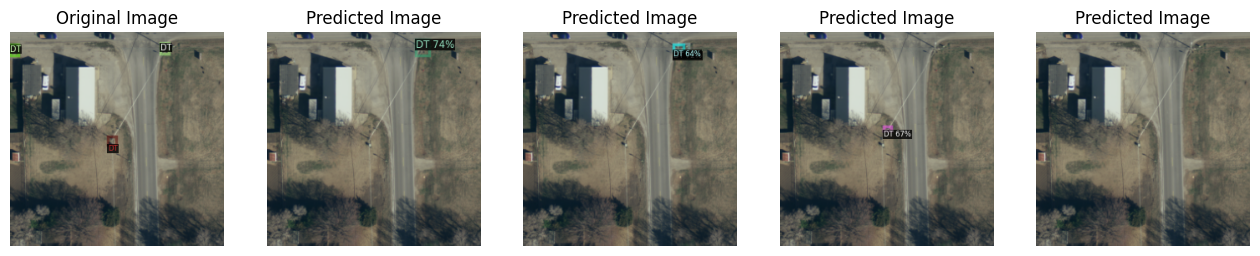

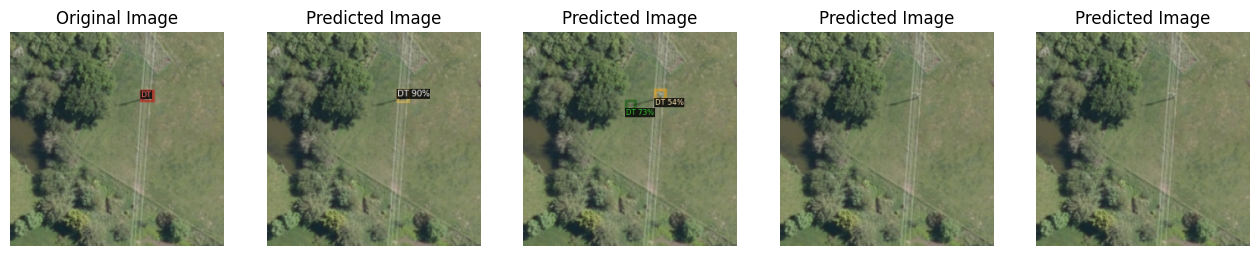

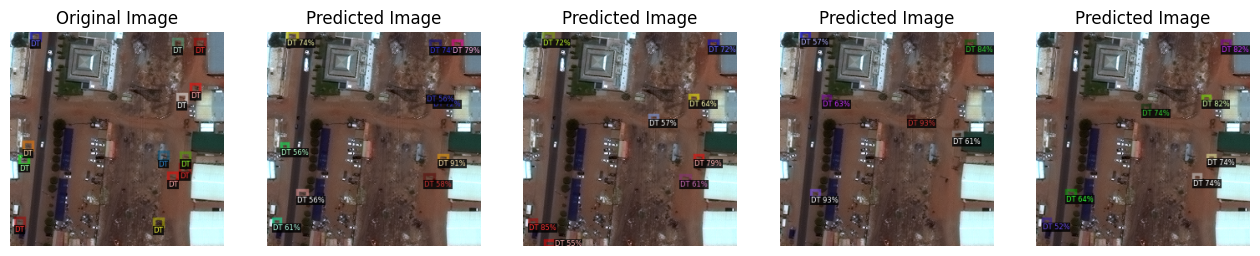

In [81]:
plot_mulitple_prediction(dataset_name_val, model_dict, file_names)

In [20]:
def plot_pred_res(dataset_name, predictor, file_names):
    
    """
    Plots a random image from a Detectron2 dataset and its corresponding predictions generated by the provided predictor.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - predictor: a Detectron2 predictor object that takes an image as input and generates predictions.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = [file for file in dataset_custom if file['file_name'][35:] in file_names]
    #image_filepaths = random.sample(dataset_custom, n)
    
    
    for s in image_filepaths: 
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
        im = cv2.imread(s["file_name"])
        
        v = Visualizer(im[:, :, ::-1], metadata=dataset_custom_metadata, scale=1.0)
        v = v.draw_dataset_dict(s)
        ax[0].imshow(v.get_image())
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        
            
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(im,#[:, :, ::-1],
                       metadata= MetadataCatalog.get(dataset_name_val), 
                       scale=0.5 
                       #,instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        ax[1].imshow(out.get_image()[:, :, ::-1])
        ax[1].axis('off')
        ax[1].set_title('Predicted Image, 100cm/p')
    
    plt.savefig('/workspace/figures/prediction_vis/image_100.png')
    
    return plt.show()


In [21]:
dataset_name_val

'100_val'

WARNING [04/16 10:00:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/16 10:00:10 d2.data.datasets.coco]: Loaded 2701 images in COCO format from /workspace/data/labels_test_DT.json


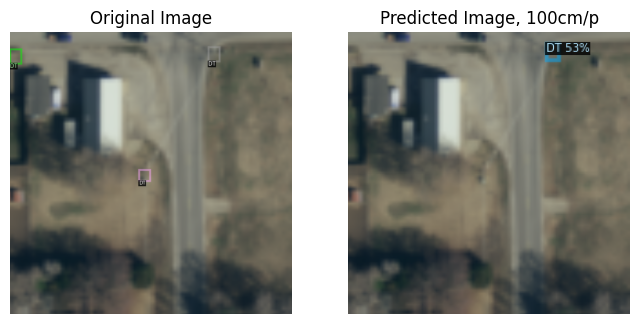

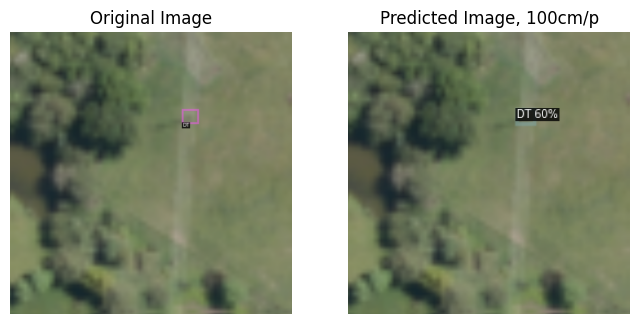

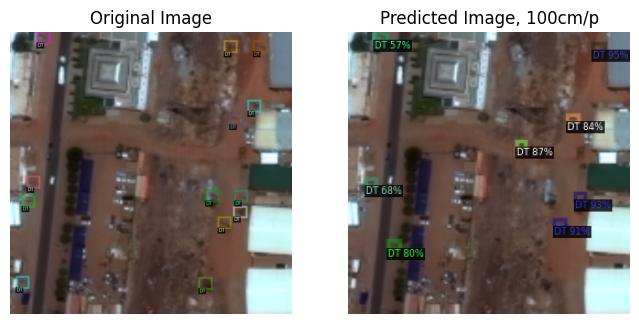

In [22]:
plot_pred_res(dataset_name_val, predictor, file_names)
